In [1]:
from __future__ import print_function, division

from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np

import os


Using TensorFlow backend.


In [2]:
def load_data():
        x_train = np.load('blues.npy',allow_pickle=True)
        x_train = x_train.reshape(len(x_train),4,4,1)
        return x_train

In [4]:
class DCGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 4
        self.img_cols = 4
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 16

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()
        generator = self.generator

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='logcosh', optimizer=optimizer)

    def build_generator(self):

        model = Sequential()
        model.add(Dense(80 * 4 * 4, activation="sigmoid", input_dim=self.latent_dim))
        model.add(Reshape((4, 4, 80)))
        model.add(Conv2D(80, kernel_size=(5,5), padding="same"))
        model.add(BatchNormalization(momentum=0.9))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(80, kernel_size=(2,2), padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(80, kernel_size=(1,1), padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(80, kernel_size=(2,2), padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(80, kernel_size=(3,3), padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(80, kernel_size=(2,2), padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(80, kernel_size=(4,4), padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(80, kernel_size=(2,2), padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.05))
        model.add(Conv2D(1, kernel_size=(2,2), padding="same"))
        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='relu'))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)
    

    def train(self, epochs, batch_size=128, save_interval=50):

        # Load the dataset
        X_train = load_data()

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        g_loss_epochs = np.zeros((epochs, 1))
        d_loss_epochs = np.zeros((epochs, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(noise, valid)
            
            #save loss history
            g_loss_epochs[epoch] = g_loss
            d_loss_epochs[epoch] = d_loss[0]

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                #self.save_imgs(epoch)
                self.generator.save("generator.h5")
        return g_loss_epochs, d_loss_epochs

In [5]:
dcgan = DCGAN()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 2, 2, 64)          640       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 2, 2, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 2, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 64)          36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 1, 64)          256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1, 1, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 1, 64)         

In [6]:
g_loss, d_loss = dcgan.train(epochs=10001, batch_size=800, save_interval=100)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


C:\Users\Vee\Anaconda3\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
C:\Users\Vee\Anaconda3\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 3.155481, acc.: 54.25%] [G loss: 0.287739]
1 [D loss: 5.275129, acc.: 41.44%] [G loss: 0.284336]


C:\Users\Vee\Anaconda3\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2 [D loss: 5.052863, acc.: 42.44%] [G loss: 0.257302]
3 [D loss: 5.155612, acc.: 43.87%] [G loss: 0.287318]
4 [D loss: 4.904381, acc.: 43.38%] [G loss: 0.267525]
5 [D loss: 5.049614, acc.: 42.88%] [G loss: 0.268957]
6 [D loss: 5.214744, acc.: 43.81%] [G loss: 0.271336]
7 [D loss: 5.001788, acc.: 43.88%] [G loss: 0.244920]
8 [D loss: 4.887587, acc.: 44.13%] [G loss: 0.256472]
9 [D loss: 5.125155, acc.: 43.12%] [G loss: 0.249018]
10 [D loss: 4.795916, acc.: 43.44%] [G loss: 0.266013]
11 [D loss: 4.787863, acc.: 45.06%] [G loss: 0.247353]
12 [D loss: 4.767972, acc.: 45.75%] [G loss: 0.249322]
13 [D loss: 4.953042, acc.: 44.37%] [G loss: 0.252730]
14 [D loss: 4.971020, acc.: 42.69%] [G loss: 0.246724]
15 [D loss: 4.894289, acc.: 44.25%] [G loss: 0.224489]
16 [D loss: 4.980143, acc.: 45.44%] [G loss: 0.241753]
17 [D loss: 4.895516, acc.: 45.06%] [G loss: 0.233662]
18 [D loss: 4.937576, acc.: 41.81%] [G loss: 0.238344]
19 [D loss: 4.617408, acc.: 45.50%] [G loss: 0.252139]
20 [D loss: 4.7353

153 [D loss: 4.685418, acc.: 45.06%] [G loss: 0.183906]
154 [D loss: 4.487282, acc.: 45.25%] [G loss: 0.167912]
155 [D loss: 4.540337, acc.: 45.81%] [G loss: 0.174585]
156 [D loss: 4.762741, acc.: 45.63%] [G loss: 0.169218]
157 [D loss: 4.464607, acc.: 46.06%] [G loss: 0.175025]
158 [D loss: 4.794353, acc.: 46.19%] [G loss: 0.186532]
159 [D loss: 4.746125, acc.: 44.12%] [G loss: 0.167678]
160 [D loss: 4.821424, acc.: 46.25%] [G loss: 0.165300]
161 [D loss: 4.764710, acc.: 43.75%] [G loss: 0.177675]
162 [D loss: 4.776849, acc.: 45.06%] [G loss: 0.160518]
163 [D loss: 4.647442, acc.: 44.37%] [G loss: 0.173068]
164 [D loss: 4.644634, acc.: 45.63%] [G loss: 0.177121]
165 [D loss: 4.823543, acc.: 44.38%] [G loss: 0.161661]
166 [D loss: 5.118836, acc.: 42.19%] [G loss: 0.181006]
167 [D loss: 4.743967, acc.: 45.75%] [G loss: 0.186932]
168 [D loss: 4.705606, acc.: 42.37%] [G loss: 0.163275]
169 [D loss: 4.913454, acc.: 42.37%] [G loss: 0.173012]
170 [D loss: 4.655312, acc.: 43.38%] [G loss: 0.

300 [D loss: 4.255742, acc.: 47.25%] [G loss: 0.184304]
301 [D loss: 4.350426, acc.: 47.50%] [G loss: 0.183050]
302 [D loss: 4.352687, acc.: 47.69%] [G loss: 0.187502]
303 [D loss: 4.700939, acc.: 45.37%] [G loss: 0.166286]
304 [D loss: 4.397167, acc.: 47.62%] [G loss: 0.181314]
305 [D loss: 4.650828, acc.: 46.69%] [G loss: 0.166851]
306 [D loss: 4.421094, acc.: 47.00%] [G loss: 0.179272]
307 [D loss: 4.784025, acc.: 44.00%] [G loss: 0.170723]
308 [D loss: 4.599214, acc.: 46.56%] [G loss: 0.163561]
309 [D loss: 4.552340, acc.: 45.87%] [G loss: 0.175665]
310 [D loss: 4.562979, acc.: 46.25%] [G loss: 0.167595]
311 [D loss: 4.647451, acc.: 46.44%] [G loss: 0.163850]
312 [D loss: 4.968855, acc.: 44.44%] [G loss: 0.172539]
313 [D loss: 4.589397, acc.: 45.00%] [G loss: 0.162789]
314 [D loss: 4.591736, acc.: 45.44%] [G loss: 0.177280]
315 [D loss: 4.596874, acc.: 46.13%] [G loss: 0.180587]
316 [D loss: 4.555858, acc.: 46.38%] [G loss: 0.168992]
317 [D loss: 4.497766, acc.: 46.94%] [G loss: 0.

448 [D loss: 4.532988, acc.: 46.75%] [G loss: 0.204733]
449 [D loss: 4.516699, acc.: 48.69%] [G loss: 0.204588]
450 [D loss: 4.403774, acc.: 47.94%] [G loss: 0.188872]
451 [D loss: 4.307353, acc.: 46.94%] [G loss: 0.195014]
452 [D loss: 4.593433, acc.: 48.31%] [G loss: 0.201030]
453 [D loss: 4.665193, acc.: 45.50%] [G loss: 0.184385]
454 [D loss: 4.266842, acc.: 45.50%] [G loss: 0.184043]
455 [D loss: 4.424143, acc.: 46.69%] [G loss: 0.214131]
456 [D loss: 3.859085, acc.: 48.50%] [G loss: 0.209279]
457 [D loss: 3.934555, acc.: 46.19%] [G loss: 0.195797]
458 [D loss: 3.774885, acc.: 49.94%] [G loss: 0.204260]
459 [D loss: 3.903183, acc.: 49.12%] [G loss: 0.192260]
460 [D loss: 4.093925, acc.: 47.69%] [G loss: 0.205446]
461 [D loss: 4.662465, acc.: 43.94%] [G loss: 0.190040]
462 [D loss: 4.440885, acc.: 47.75%] [G loss: 0.176591]
463 [D loss: 4.353332, acc.: 47.94%] [G loss: 0.189260]
464 [D loss: 4.501443, acc.: 47.31%] [G loss: 0.179933]
465 [D loss: 4.392966, acc.: 46.44%] [G loss: 0.

595 [D loss: 4.719277, acc.: 44.19%] [G loss: 0.217210]
596 [D loss: 4.689873, acc.: 46.19%] [G loss: 0.217156]
597 [D loss: 4.282690, acc.: 47.12%] [G loss: 0.233189]
598 [D loss: 4.438776, acc.: 43.50%] [G loss: 0.238060]
599 [D loss: 4.395905, acc.: 45.63%] [G loss: 0.227816]
600 [D loss: 4.508056, acc.: 45.56%] [G loss: 0.222684]
601 [D loss: 4.568183, acc.: 46.00%] [G loss: 0.226144]
602 [D loss: 4.628050, acc.: 43.69%] [G loss: 0.217653]
603 [D loss: 4.411887, acc.: 45.75%] [G loss: 0.219061]
604 [D loss: 4.259369, acc.: 45.88%] [G loss: 0.219413]
605 [D loss: 4.234413, acc.: 47.37%] [G loss: 0.207188]
606 [D loss: 4.371528, acc.: 47.19%] [G loss: 0.217157]
607 [D loss: 4.290494, acc.: 45.69%] [G loss: 0.239649]
608 [D loss: 4.211336, acc.: 47.50%] [G loss: 0.219124]
609 [D loss: 4.265662, acc.: 46.81%] [G loss: 0.208893]
610 [D loss: 4.037832, acc.: 49.88%] [G loss: 0.223169]
611 [D loss: 4.207085, acc.: 47.62%] [G loss: 0.234776]
612 [D loss: 4.159465, acc.: 48.00%] [G loss: 0.

743 [D loss: 4.210461, acc.: 48.75%] [G loss: 0.190250]
744 [D loss: 4.232994, acc.: 48.00%] [G loss: 0.188099]
745 [D loss: 4.210004, acc.: 45.44%] [G loss: 0.201346]
746 [D loss: 4.130143, acc.: 46.56%] [G loss: 0.202557]
747 [D loss: 4.175510, acc.: 45.06%] [G loss: 0.191400]
748 [D loss: 4.200660, acc.: 45.94%] [G loss: 0.194705]
749 [D loss: 4.059783, acc.: 48.50%] [G loss: 0.200682]
750 [D loss: 4.352698, acc.: 45.75%] [G loss: 0.196103]
751 [D loss: 4.192466, acc.: 48.19%] [G loss: 0.187643]
752 [D loss: 4.172569, acc.: 47.31%] [G loss: 0.190092]
753 [D loss: 4.102479, acc.: 47.75%] [G loss: 0.197675]
754 [D loss: 4.160825, acc.: 48.06%] [G loss: 0.182855]
755 [D loss: 3.878583, acc.: 49.19%] [G loss: 0.192076]
756 [D loss: 4.140359, acc.: 48.81%] [G loss: 0.188235]
757 [D loss: 4.299157, acc.: 46.50%] [G loss: 0.197961]
758 [D loss: 4.204498, acc.: 48.19%] [G loss: 0.200150]
759 [D loss: 4.035183, acc.: 46.88%] [G loss: 0.186343]
760 [D loss: 3.886849, acc.: 49.44%] [G loss: 0.

890 [D loss: 4.433478, acc.: 46.19%] [G loss: 0.165629]
891 [D loss: 4.530725, acc.: 44.88%] [G loss: 0.171801]
892 [D loss: 4.336246, acc.: 46.38%] [G loss: 0.171052]
893 [D loss: 4.267730, acc.: 45.00%] [G loss: 0.175918]
894 [D loss: 4.259110, acc.: 48.50%] [G loss: 0.176393]
895 [D loss: 4.523542, acc.: 45.56%] [G loss: 0.173393]
896 [D loss: 4.425646, acc.: 46.56%] [G loss: 0.184064]
897 [D loss: 4.313115, acc.: 46.38%] [G loss: 0.174413]
898 [D loss: 4.206262, acc.: 46.06%] [G loss: 0.169526]
899 [D loss: 4.079772, acc.: 46.31%] [G loss: 0.177845]
900 [D loss: 4.191334, acc.: 47.00%] [G loss: 0.166390]
901 [D loss: 4.383863, acc.: 46.69%] [G loss: 0.168991]
902 [D loss: 4.368439, acc.: 46.56%] [G loss: 0.185381]
903 [D loss: 4.253034, acc.: 46.63%] [G loss: 0.173073]
904 [D loss: 4.224856, acc.: 46.94%] [G loss: 0.167224]
905 [D loss: 4.233790, acc.: 46.69%] [G loss: 0.171294]
906 [D loss: 4.271300, acc.: 45.38%] [G loss: 0.172063]
907 [D loss: 4.622143, acc.: 45.38%] [G loss: 0.

1036 [D loss: 3.764173, acc.: 47.56%] [G loss: 0.167812]
1037 [D loss: 4.068783, acc.: 47.81%] [G loss: 0.163500]
1038 [D loss: 3.909355, acc.: 48.19%] [G loss: 0.176187]
1039 [D loss: 4.203494, acc.: 46.69%] [G loss: 0.162450]
1040 [D loss: 4.180731, acc.: 47.12%] [G loss: 0.164477]
1041 [D loss: 3.987466, acc.: 47.50%] [G loss: 0.165108]
1042 [D loss: 4.169513, acc.: 47.69%] [G loss: 0.158244]
1043 [D loss: 4.170004, acc.: 47.75%] [G loss: 0.174095]
1044 [D loss: 4.048829, acc.: 47.19%] [G loss: 0.168678]
1045 [D loss: 4.239970, acc.: 48.00%] [G loss: 0.175167]
1046 [D loss: 4.050896, acc.: 48.12%] [G loss: 0.174241]
1047 [D loss: 4.022773, acc.: 48.31%] [G loss: 0.166827]
1048 [D loss: 4.128392, acc.: 47.69%] [G loss: 0.177022]
1049 [D loss: 4.207962, acc.: 46.13%] [G loss: 0.180472]
1050 [D loss: 4.137577, acc.: 47.25%] [G loss: 0.164287]
1051 [D loss: 4.023197, acc.: 48.75%] [G loss: 0.164668]
1052 [D loss: 3.939278, acc.: 45.75%] [G loss: 0.158334]
1053 [D loss: 4.165721, acc.: 4

1180 [D loss: 4.158479, acc.: 46.50%] [G loss: 0.162624]
1181 [D loss: 4.156044, acc.: 47.31%] [G loss: 0.165571]
1182 [D loss: 4.085312, acc.: 46.38%] [G loss: 0.164797]
1183 [D loss: 4.051890, acc.: 48.56%] [G loss: 0.167087]
1184 [D loss: 3.887321, acc.: 47.69%] [G loss: 0.167612]
1185 [D loss: 4.025302, acc.: 46.94%] [G loss: 0.165837]
1186 [D loss: 3.884783, acc.: 47.06%] [G loss: 0.168310]
1187 [D loss: 3.893077, acc.: 48.81%] [G loss: 0.181774]
1188 [D loss: 4.113225, acc.: 45.25%] [G loss: 0.170145]
1189 [D loss: 4.101604, acc.: 47.50%] [G loss: 0.162134]
1190 [D loss: 4.001967, acc.: 47.31%] [G loss: 0.177573]
1191 [D loss: 4.346374, acc.: 45.00%] [G loss: 0.165480]
1192 [D loss: 4.025650, acc.: 47.06%] [G loss: 0.181775]
1193 [D loss: 4.122106, acc.: 46.25%] [G loss: 0.156064]
1194 [D loss: 3.969910, acc.: 47.00%] [G loss: 0.168890]
1195 [D loss: 4.198081, acc.: 46.25%] [G loss: 0.165601]
1196 [D loss: 4.217115, acc.: 45.19%] [G loss: 0.174005]
1197 [D loss: 4.012405, acc.: 4

1326 [D loss: 4.130687, acc.: 48.06%] [G loss: 0.161148]
1327 [D loss: 4.139513, acc.: 47.31%] [G loss: 0.164343]
1328 [D loss: 4.041372, acc.: 47.81%] [G loss: 0.157005]
1329 [D loss: 3.936187, acc.: 48.19%] [G loss: 0.160307]
1330 [D loss: 3.861795, acc.: 50.31%] [G loss: 0.151109]
1331 [D loss: 3.969322, acc.: 47.19%] [G loss: 0.157020]
1332 [D loss: 3.860714, acc.: 48.44%] [G loss: 0.172375]
1333 [D loss: 3.983883, acc.: 48.56%] [G loss: 0.158767]
1334 [D loss: 3.996140, acc.: 48.06%] [G loss: 0.161408]
1335 [D loss: 4.183161, acc.: 46.75%] [G loss: 0.168066]
1336 [D loss: 4.058756, acc.: 46.63%] [G loss: 0.165004]
1337 [D loss: 3.969419, acc.: 46.19%] [G loss: 0.158975]
1338 [D loss: 4.063704, acc.: 45.31%] [G loss: 0.160868]
1339 [D loss: 4.129960, acc.: 44.94%] [G loss: 0.167870]
1340 [D loss: 4.286862, acc.: 45.69%] [G loss: 0.152525]
1341 [D loss: 4.129377, acc.: 44.63%] [G loss: 0.153544]
1342 [D loss: 3.874079, acc.: 46.25%] [G loss: 0.150714]
1343 [D loss: 4.022291, acc.: 4

1471 [D loss: 4.100284, acc.: 44.31%] [G loss: 0.137184]
1472 [D loss: 4.017020, acc.: 45.06%] [G loss: 0.140856]
1473 [D loss: 3.849760, acc.: 46.38%] [G loss: 0.147098]
1474 [D loss: 3.946343, acc.: 45.06%] [G loss: 0.143975]
1475 [D loss: 4.194026, acc.: 46.38%] [G loss: 0.141903]
1476 [D loss: 3.910894, acc.: 46.56%] [G loss: 0.143720]
1477 [D loss: 3.907215, acc.: 47.25%] [G loss: 0.139704]
1478 [D loss: 4.090282, acc.: 45.44%] [G loss: 0.142816]
1479 [D loss: 3.930773, acc.: 46.38%] [G loss: 0.140493]
1480 [D loss: 3.992282, acc.: 45.63%] [G loss: 0.135939]
1481 [D loss: 4.119475, acc.: 44.94%] [G loss: 0.138677]
1482 [D loss: 3.899426, acc.: 46.56%] [G loss: 0.153472]
1483 [D loss: 4.477990, acc.: 44.25%] [G loss: 0.145296]
1484 [D loss: 4.049570, acc.: 44.25%] [G loss: 0.143972]
1485 [D loss: 4.005431, acc.: 45.38%] [G loss: 0.152810]
1486 [D loss: 4.237989, acc.: 45.06%] [G loss: 0.150138]
1487 [D loss: 4.190617, acc.: 44.25%] [G loss: 0.146484]
1488 [D loss: 4.172913, acc.: 4

1615 [D loss: 3.360051, acc.: 49.00%] [G loss: 0.137914]
1616 [D loss: 3.743966, acc.: 48.50%] [G loss: 0.135700]
1617 [D loss: 3.676811, acc.: 47.44%] [G loss: 0.139900]
1618 [D loss: 3.860181, acc.: 47.75%] [G loss: 0.137555]
1619 [D loss: 3.648240, acc.: 49.38%] [G loss: 0.130423]
1620 [D loss: 3.838972, acc.: 46.69%] [G loss: 0.131897]
1621 [D loss: 3.364867, acc.: 49.44%] [G loss: 0.137843]
1622 [D loss: 3.430865, acc.: 49.88%] [G loss: 0.142322]
1623 [D loss: 3.929351, acc.: 45.44%] [G loss: 0.140545]
1624 [D loss: 3.920832, acc.: 48.37%] [G loss: 0.142744]
1625 [D loss: 3.817079, acc.: 45.31%] [G loss: 0.134584]
1626 [D loss: 3.739034, acc.: 46.44%] [G loss: 0.147840]
1627 [D loss: 3.842100, acc.: 45.56%] [G loss: 0.128778]
1628 [D loss: 4.046542, acc.: 46.75%] [G loss: 0.130122]
1629 [D loss: 3.841602, acc.: 46.50%] [G loss: 0.134409]
1630 [D loss: 3.998420, acc.: 45.38%] [G loss: 0.128349]
1631 [D loss: 3.804670, acc.: 45.94%] [G loss: 0.133445]
1632 [D loss: 3.777358, acc.: 4

1760 [D loss: 3.050686, acc.: 50.81%] [G loss: 0.138481]
1761 [D loss: 2.911956, acc.: 51.56%] [G loss: 0.129865]
1762 [D loss: 3.246544, acc.: 49.38%] [G loss: 0.140473]
1763 [D loss: 2.889782, acc.: 49.94%] [G loss: 0.134306]
1764 [D loss: 3.122529, acc.: 46.31%] [G loss: 0.131082]
1765 [D loss: 3.220532, acc.: 47.87%] [G loss: 0.122134]
1766 [D loss: 3.107929, acc.: 49.81%] [G loss: 0.142699]
1767 [D loss: 2.891527, acc.: 49.75%] [G loss: 0.140779]
1768 [D loss: 3.241966, acc.: 46.63%] [G loss: 0.135708]
1769 [D loss: 2.845806, acc.: 52.88%] [G loss: 0.139900]
1770 [D loss: 2.978163, acc.: 50.69%] [G loss: 0.136949]
1771 [D loss: 3.064642, acc.: 51.50%] [G loss: 0.131905]
1772 [D loss: 2.876935, acc.: 49.87%] [G loss: 0.147562]
1773 [D loss: 2.860953, acc.: 53.44%] [G loss: 0.139128]
1774 [D loss: 2.695749, acc.: 55.06%] [G loss: 0.142179]
1775 [D loss: 2.690942, acc.: 55.75%] [G loss: 0.132211]
1776 [D loss: 2.998692, acc.: 49.75%] [G loss: 0.125047]
1777 [D loss: 2.918288, acc.: 4

1905 [D loss: 2.927941, acc.: 50.38%] [G loss: 0.140766]
1906 [D loss: 3.057636, acc.: 50.63%] [G loss: 0.151018]
1907 [D loss: 2.933986, acc.: 50.88%] [G loss: 0.145157]
1908 [D loss: 3.211299, acc.: 47.31%] [G loss: 0.135614]
1909 [D loss: 3.272377, acc.: 47.12%] [G loss: 0.135036]
1910 [D loss: 3.059228, acc.: 49.06%] [G loss: 0.139594]
1911 [D loss: 2.817487, acc.: 51.50%] [G loss: 0.136333]
1912 [D loss: 3.227728, acc.: 48.44%] [G loss: 0.140246]
1913 [D loss: 2.819326, acc.: 53.00%] [G loss: 0.143415]
1914 [D loss: 3.278045, acc.: 48.19%] [G loss: 0.138788]
1915 [D loss: 3.145775, acc.: 49.69%] [G loss: 0.141744]
1916 [D loss: 3.243045, acc.: 48.87%] [G loss: 0.142605]
1917 [D loss: 3.068270, acc.: 46.00%] [G loss: 0.140070]
1918 [D loss: 2.881046, acc.: 53.06%] [G loss: 0.142057]
1919 [D loss: 2.895839, acc.: 48.19%] [G loss: 0.128547]
1920 [D loss: 2.929026, acc.: 48.50%] [G loss: 0.155223]
1921 [D loss: 2.810057, acc.: 52.88%] [G loss: 0.132576]
1922 [D loss: 2.882352, acc.: 5

2049 [D loss: 2.846053, acc.: 49.75%] [G loss: 0.122162]
2050 [D loss: 2.876599, acc.: 45.69%] [G loss: 0.125333]
2051 [D loss: 2.620341, acc.: 49.06%] [G loss: 0.122779]
2052 [D loss: 2.976761, acc.: 48.81%] [G loss: 0.129301]
2053 [D loss: 2.905856, acc.: 44.94%] [G loss: 0.120868]
2054 [D loss: 3.138610, acc.: 46.75%] [G loss: 0.135514]
2055 [D loss: 2.862652, acc.: 46.69%] [G loss: 0.121767]
2056 [D loss: 2.890046, acc.: 47.69%] [G loss: 0.127613]
2057 [D loss: 2.721683, acc.: 49.75%] [G loss: 0.130321]
2058 [D loss: 2.774289, acc.: 50.31%] [G loss: 0.126594]
2059 [D loss: 2.713483, acc.: 47.06%] [G loss: 0.116947]
2060 [D loss: 2.682487, acc.: 49.56%] [G loss: 0.120766]
2061 [D loss: 2.636976, acc.: 49.31%] [G loss: 0.121418]
2062 [D loss: 2.592219, acc.: 52.13%] [G loss: 0.122828]
2063 [D loss: 2.517207, acc.: 54.94%] [G loss: 0.127065]
2064 [D loss: 2.574589, acc.: 52.31%] [G loss: 0.127672]
2065 [D loss: 2.708438, acc.: 52.63%] [G loss: 0.119386]
2066 [D loss: 2.591573, acc.: 5

2195 [D loss: 2.860798, acc.: 52.44%] [G loss: 0.130625]
2196 [D loss: 2.971971, acc.: 49.25%] [G loss: 0.130693]
2197 [D loss: 2.872555, acc.: 50.75%] [G loss: 0.133589]
2198 [D loss: 3.132076, acc.: 47.31%] [G loss: 0.121604]
2199 [D loss: 2.873215, acc.: 47.37%] [G loss: 0.132426]
2200 [D loss: 3.106849, acc.: 47.87%] [G loss: 0.129749]
2201 [D loss: 3.413672, acc.: 44.31%] [G loss: 0.134003]
2202 [D loss: 3.164722, acc.: 48.38%] [G loss: 0.126419]
2203 [D loss: 3.227014, acc.: 45.94%] [G loss: 0.127303]
2204 [D loss: 3.291141, acc.: 45.31%] [G loss: 0.134761]
2205 [D loss: 3.009677, acc.: 46.44%] [G loss: 0.133479]
2206 [D loss: 3.052287, acc.: 47.87%] [G loss: 0.127533]
2207 [D loss: 2.986027, acc.: 47.94%] [G loss: 0.127997]
2208 [D loss: 3.576953, acc.: 44.75%] [G loss: 0.125863]
2209 [D loss: 3.039869, acc.: 45.88%] [G loss: 0.149367]
2210 [D loss: 3.114333, acc.: 48.56%] [G loss: 0.113945]
2211 [D loss: 3.267566, acc.: 48.69%] [G loss: 0.117187]
2212 [D loss: 3.387203, acc.: 4

2339 [D loss: 2.864924, acc.: 49.63%] [G loss: 0.131928]
2340 [D loss: 2.782367, acc.: 49.94%] [G loss: 0.136135]
2341 [D loss: 2.724505, acc.: 51.44%] [G loss: 0.127195]
2342 [D loss: 2.823111, acc.: 50.19%] [G loss: 0.130952]
2343 [D loss: 2.730389, acc.: 51.69%] [G loss: 0.127241]
2344 [D loss: 2.880945, acc.: 50.44%] [G loss: 0.140104]
2345 [D loss: 2.807503, acc.: 51.38%] [G loss: 0.149232]
2346 [D loss: 2.608549, acc.: 52.50%] [G loss: 0.141557]
2347 [D loss: 2.838290, acc.: 49.06%] [G loss: 0.139988]
2348 [D loss: 2.754394, acc.: 49.75%] [G loss: 0.131782]
2349 [D loss: 2.646095, acc.: 50.75%] [G loss: 0.131203]
2350 [D loss: 2.932037, acc.: 49.19%] [G loss: 0.138118]
2351 [D loss: 3.011007, acc.: 50.87%] [G loss: 0.125558]
2352 [D loss: 2.855973, acc.: 47.50%] [G loss: 0.137208]
2353 [D loss: 2.865644, acc.: 50.44%] [G loss: 0.147076]
2354 [D loss: 3.170247, acc.: 48.31%] [G loss: 0.143484]
2355 [D loss: 2.897903, acc.: 47.44%] [G loss: 0.145288]
2356 [D loss: 3.151563, acc.: 4

2484 [D loss: 2.569040, acc.: 53.69%] [G loss: 0.171995]
2485 [D loss: 2.852583, acc.: 51.13%] [G loss: 0.155184]
2486 [D loss: 2.681773, acc.: 48.81%] [G loss: 0.159960]
2487 [D loss: 2.697395, acc.: 52.44%] [G loss: 0.172515]
2488 [D loss: 2.777837, acc.: 50.81%] [G loss: 0.176710]
2489 [D loss: 2.464555, acc.: 53.75%] [G loss: 0.155179]
2490 [D loss: 2.492614, acc.: 54.31%] [G loss: 0.138913]
2491 [D loss: 2.534366, acc.: 53.31%] [G loss: 0.162845]
2492 [D loss: 2.476033, acc.: 50.63%] [G loss: 0.154304]
2493 [D loss: 2.631472, acc.: 53.81%] [G loss: 0.168779]
2494 [D loss: 2.563027, acc.: 52.00%] [G loss: 0.159469]
2495 [D loss: 2.568258, acc.: 51.00%] [G loss: 0.158279]
2496 [D loss: 3.094448, acc.: 49.25%] [G loss: 0.170711]
2497 [D loss: 2.912276, acc.: 50.69%] [G loss: 0.162096]
2498 [D loss: 2.590725, acc.: 51.13%] [G loss: 0.154350]
2499 [D loss: 2.620898, acc.: 54.56%] [G loss: 0.149495]
2500 [D loss: 2.689842, acc.: 53.19%] [G loss: 0.153053]
2501 [D loss: 2.942576, acc.: 4

2630 [D loss: 3.080537, acc.: 44.56%] [G loss: 0.161472]
2631 [D loss: 3.310031, acc.: 43.63%] [G loss: 0.169017]
2632 [D loss: 2.947436, acc.: 49.62%] [G loss: 0.156233]
2633 [D loss: 3.335814, acc.: 45.00%] [G loss: 0.165714]
2634 [D loss: 2.970481, acc.: 47.31%] [G loss: 0.162407]
2635 [D loss: 3.159320, acc.: 46.69%] [G loss: 0.150076]
2636 [D loss: 3.502589, acc.: 45.25%] [G loss: 0.163215]
2637 [D loss: 3.191090, acc.: 46.69%] [G loss: 0.150102]
2638 [D loss: 3.295182, acc.: 46.44%] [G loss: 0.149951]
2639 [D loss: 3.014319, acc.: 47.37%] [G loss: 0.163633]
2640 [D loss: 3.195880, acc.: 46.94%] [G loss: 0.166087]
2641 [D loss: 3.037793, acc.: 48.50%] [G loss: 0.161001]
2642 [D loss: 3.096208, acc.: 46.75%] [G loss: 0.158152]
2643 [D loss: 3.474570, acc.: 45.38%] [G loss: 0.156230]
2644 [D loss: 3.218343, acc.: 45.63%] [G loss: 0.163803]
2645 [D loss: 3.333348, acc.: 46.88%] [G loss: 0.161959]
2646 [D loss: 3.309011, acc.: 46.00%] [G loss: 0.164857]
2647 [D loss: 3.552846, acc.: 4

2776 [D loss: 2.987913, acc.: 46.94%] [G loss: 0.159146]
2777 [D loss: 2.831177, acc.: 49.81%] [G loss: 0.161292]
2778 [D loss: 2.852924, acc.: 47.44%] [G loss: 0.164542]
2779 [D loss: 2.706003, acc.: 48.19%] [G loss: 0.173256]
2780 [D loss: 3.032438, acc.: 49.38%] [G loss: 0.163555]
2781 [D loss: 2.908832, acc.: 49.94%] [G loss: 0.152442]
2782 [D loss: 2.856402, acc.: 50.56%] [G loss: 0.169472]
2783 [D loss: 3.035912, acc.: 48.94%] [G loss: 0.149123]
2784 [D loss: 2.840733, acc.: 47.69%] [G loss: 0.163077]
2785 [D loss: 2.744396, acc.: 49.25%] [G loss: 0.161758]
2786 [D loss: 2.877038, acc.: 49.69%] [G loss: 0.162665]
2787 [D loss: 2.761168, acc.: 49.63%] [G loss: 0.171290]
2788 [D loss: 2.571798, acc.: 50.87%] [G loss: 0.160464]
2789 [D loss: 2.934098, acc.: 45.25%] [G loss: 0.161375]
2790 [D loss: 2.832021, acc.: 48.12%] [G loss: 0.169958]
2791 [D loss: 2.714449, acc.: 48.94%] [G loss: 0.149696]
2792 [D loss: 2.764411, acc.: 51.06%] [G loss: 0.148011]
2793 [D loss: 3.014812, acc.: 4

2920 [D loss: 3.419740, acc.: 45.25%] [G loss: 0.159614]
2921 [D loss: 3.553030, acc.: 43.50%] [G loss: 0.168221]
2922 [D loss: 3.334599, acc.: 46.06%] [G loss: 0.165347]
2923 [D loss: 3.461083, acc.: 45.13%] [G loss: 0.165482]
2924 [D loss: 3.480420, acc.: 44.75%] [G loss: 0.170280]
2925 [D loss: 3.307999, acc.: 45.88%] [G loss: 0.174462]
2926 [D loss: 3.323226, acc.: 45.63%] [G loss: 0.187736]
2927 [D loss: 3.623491, acc.: 42.44%] [G loss: 0.153404]
2928 [D loss: 3.544676, acc.: 42.44%] [G loss: 0.188922]
2929 [D loss: 3.481229, acc.: 45.69%] [G loss: 0.178195]
2930 [D loss: 3.698756, acc.: 43.06%] [G loss: 0.174109]
2931 [D loss: 3.687383, acc.: 44.13%] [G loss: 0.172234]
2932 [D loss: 3.325556, acc.: 45.25%] [G loss: 0.174429]
2933 [D loss: 3.639400, acc.: 45.88%] [G loss: 0.174078]
2934 [D loss: 3.410143, acc.: 45.63%] [G loss: 0.168171]
2935 [D loss: 3.393384, acc.: 44.94%] [G loss: 0.170490]
2936 [D loss: 3.412655, acc.: 45.44%] [G loss: 0.162258]
2937 [D loss: 3.597372, acc.: 4

3065 [D loss: 3.136725, acc.: 47.81%] [G loss: 0.167635]
3066 [D loss: 3.354536, acc.: 46.56%] [G loss: 0.165278]
3067 [D loss: 3.460269, acc.: 47.06%] [G loss: 0.169982]
3068 [D loss: 3.397616, acc.: 45.13%] [G loss: 0.175122]
3069 [D loss: 3.502330, acc.: 46.88%] [G loss: 0.156598]
3070 [D loss: 3.446810, acc.: 46.06%] [G loss: 0.162696]
3071 [D loss: 3.432536, acc.: 45.63%] [G loss: 0.167618]
3072 [D loss: 3.438113, acc.: 45.19%] [G loss: 0.168000]
3073 [D loss: 3.523908, acc.: 45.63%] [G loss: 0.182738]
3074 [D loss: 3.427887, acc.: 42.81%] [G loss: 0.169781]
3075 [D loss: 3.459857, acc.: 45.31%] [G loss: 0.169940]
3076 [D loss: 3.529117, acc.: 45.13%] [G loss: 0.162748]
3077 [D loss: 3.299637, acc.: 45.75%] [G loss: 0.171473]
3078 [D loss: 3.416017, acc.: 47.62%] [G loss: 0.199256]
3079 [D loss: 3.208205, acc.: 46.38%] [G loss: 0.175707]
3080 [D loss: 3.247404, acc.: 46.13%] [G loss: 0.176356]
3081 [D loss: 3.440689, acc.: 44.06%] [G loss: 0.188631]
3082 [D loss: 3.472089, acc.: 4

3211 [D loss: 3.180967, acc.: 49.06%] [G loss: 0.174737]
3212 [D loss: 2.983997, acc.: 48.50%] [G loss: 0.184119]
3213 [D loss: 3.003502, acc.: 48.44%] [G loss: 0.173738]
3214 [D loss: 3.068910, acc.: 49.06%] [G loss: 0.180424]
3215 [D loss: 3.270448, acc.: 47.12%] [G loss: 0.162379]
3216 [D loss: 3.151918, acc.: 48.37%] [G loss: 0.167433]
3217 [D loss: 3.087578, acc.: 49.81%] [G loss: 0.168060]
3218 [D loss: 3.317665, acc.: 46.25%] [G loss: 0.175381]
3219 [D loss: 3.190770, acc.: 47.62%] [G loss: 0.170181]
3220 [D loss: 3.206530, acc.: 48.37%] [G loss: 0.168924]
3221 [D loss: 3.142306, acc.: 48.00%] [G loss: 0.157972]
3222 [D loss: 3.257480, acc.: 45.31%] [G loss: 0.170151]
3223 [D loss: 3.119220, acc.: 46.75%] [G loss: 0.165865]
3224 [D loss: 3.016167, acc.: 48.63%] [G loss: 0.172774]
3225 [D loss: 3.150470, acc.: 48.25%] [G loss: 0.175202]
3226 [D loss: 3.041514, acc.: 47.31%] [G loss: 0.174215]
3227 [D loss: 3.069682, acc.: 46.00%] [G loss: 0.168990]
3228 [D loss: 3.098658, acc.: 4

3355 [D loss: 3.070081, acc.: 47.31%] [G loss: 0.160129]
3356 [D loss: 3.065473, acc.: 48.44%] [G loss: 0.181861]
3357 [D loss: 2.856688, acc.: 49.94%] [G loss: 0.165985]
3358 [D loss: 2.810003, acc.: 49.56%] [G loss: 0.174268]
3359 [D loss: 3.022563, acc.: 47.75%] [G loss: 0.177074]
3360 [D loss: 2.985951, acc.: 48.69%] [G loss: 0.177114]
3361 [D loss: 3.199230, acc.: 48.50%] [G loss: 0.183171]
3362 [D loss: 3.084887, acc.: 47.00%] [G loss: 0.168945]
3363 [D loss: 3.215683, acc.: 46.19%] [G loss: 0.165270]
3364 [D loss: 3.325708, acc.: 45.69%] [G loss: 0.163724]
3365 [D loss: 3.177662, acc.: 45.50%] [G loss: 0.156118]
3366 [D loss: 3.174153, acc.: 48.12%] [G loss: 0.160270]
3367 [D loss: 3.180789, acc.: 46.06%] [G loss: 0.157624]
3368 [D loss: 3.278134, acc.: 46.75%] [G loss: 0.166449]
3369 [D loss: 3.226914, acc.: 46.38%] [G loss: 0.158963]
3370 [D loss: 2.989856, acc.: 48.62%] [G loss: 0.171000]
3371 [D loss: 2.999358, acc.: 48.06%] [G loss: 0.157893]
3372 [D loss: 3.250340, acc.: 4

3500 [D loss: 3.523752, acc.: 45.44%] [G loss: 0.189500]
3501 [D loss: 3.313886, acc.: 46.06%] [G loss: 0.183254]
3502 [D loss: 3.515125, acc.: 44.19%] [G loss: 0.174544]
3503 [D loss: 3.435352, acc.: 44.37%] [G loss: 0.178905]
3504 [D loss: 3.283200, acc.: 47.00%] [G loss: 0.167037]
3505 [D loss: 3.088410, acc.: 46.56%] [G loss: 0.181889]
3506 [D loss: 3.302851, acc.: 46.94%] [G loss: 0.172473]
3507 [D loss: 2.966248, acc.: 48.38%] [G loss: 0.163997]
3508 [D loss: 2.981920, acc.: 47.94%] [G loss: 0.181967]
3509 [D loss: 3.011045, acc.: 49.50%] [G loss: 0.176319]
3510 [D loss: 3.019888, acc.: 49.81%] [G loss: 0.182862]
3511 [D loss: 3.092894, acc.: 46.88%] [G loss: 0.192839]
3512 [D loss: 3.002264, acc.: 48.13%] [G loss: 0.161853]
3513 [D loss: 3.248588, acc.: 48.31%] [G loss: 0.180253]
3514 [D loss: 2.815780, acc.: 51.31%] [G loss: 0.172780]
3515 [D loss: 2.814747, acc.: 50.75%] [G loss: 0.168232]
3516 [D loss: 2.761384, acc.: 50.31%] [G loss: 0.162145]
3517 [D loss: 2.895546, acc.: 4

3645 [D loss: 2.764676, acc.: 51.19%] [G loss: 0.144792]
3646 [D loss: 2.523513, acc.: 54.06%] [G loss: 0.137005]
3647 [D loss: 2.740727, acc.: 51.31%] [G loss: 0.135144]
3648 [D loss: 2.855180, acc.: 49.94%] [G loss: 0.163767]
3649 [D loss: 2.600448, acc.: 52.00%] [G loss: 0.137044]
3650 [D loss: 2.636670, acc.: 51.50%] [G loss: 0.136827]
3651 [D loss: 2.608204, acc.: 52.13%] [G loss: 0.150073]
3652 [D loss: 2.636174, acc.: 51.75%] [G loss: 0.138175]
3653 [D loss: 2.771716, acc.: 51.06%] [G loss: 0.149407]
3654 [D loss: 2.690723, acc.: 50.13%] [G loss: 0.144642]
3655 [D loss: 2.647408, acc.: 49.81%] [G loss: 0.151122]
3656 [D loss: 2.614551, acc.: 50.50%] [G loss: 0.136325]
3657 [D loss: 2.861225, acc.: 49.81%] [G loss: 0.151259]
3658 [D loss: 2.405660, acc.: 54.69%] [G loss: 0.163868]
3659 [D loss: 2.636386, acc.: 52.19%] [G loss: 0.154772]
3660 [D loss: 2.561194, acc.: 53.87%] [G loss: 0.144338]
3661 [D loss: 2.863858, acc.: 52.56%] [G loss: 0.148799]
3662 [D loss: 2.817830, acc.: 5

3789 [D loss: 2.587626, acc.: 51.25%] [G loss: 0.144022]
3790 [D loss: 2.840592, acc.: 50.37%] [G loss: 0.141326]
3791 [D loss: 2.536403, acc.: 52.19%] [G loss: 0.143837]
3792 [D loss: 2.928101, acc.: 49.75%] [G loss: 0.139033]
3793 [D loss: 3.075572, acc.: 49.00%] [G loss: 0.148737]
3794 [D loss: 2.942996, acc.: 48.88%] [G loss: 0.144174]
3795 [D loss: 3.076806, acc.: 49.44%] [G loss: 0.156432]
3796 [D loss: 2.975395, acc.: 48.12%] [G loss: 0.131822]
3797 [D loss: 3.224570, acc.: 48.12%] [G loss: 0.142722]
3798 [D loss: 2.899814, acc.: 48.69%] [G loss: 0.141734]
3799 [D loss: 3.201971, acc.: 47.25%] [G loss: 0.149810]
3800 [D loss: 3.021886, acc.: 47.50%] [G loss: 0.160650]
3801 [D loss: 2.937394, acc.: 47.69%] [G loss: 0.135337]
3802 [D loss: 3.083346, acc.: 46.94%] [G loss: 0.136786]
3803 [D loss: 3.083771, acc.: 48.12%] [G loss: 0.139561]
3804 [D loss: 2.830168, acc.: 48.56%] [G loss: 0.147086]
3805 [D loss: 2.983822, acc.: 46.75%] [G loss: 0.145816]
3806 [D loss: 3.116571, acc.: 4

3934 [D loss: 2.784813, acc.: 51.06%] [G loss: 0.130914]
3935 [D loss: 2.326175, acc.: 52.56%] [G loss: 0.124094]
3936 [D loss: 2.757608, acc.: 49.00%] [G loss: 0.136107]
3937 [D loss: 2.624342, acc.: 48.81%] [G loss: 0.133818]
3938 [D loss: 2.533357, acc.: 48.81%] [G loss: 0.138055]
3939 [D loss: 2.601659, acc.: 51.38%] [G loss: 0.141232]
3940 [D loss: 2.387188, acc.: 54.87%] [G loss: 0.146872]
3941 [D loss: 2.499132, acc.: 50.19%] [G loss: 0.138337]
3942 [D loss: 2.325524, acc.: 51.50%] [G loss: 0.133235]
3943 [D loss: 2.777487, acc.: 47.25%] [G loss: 0.124064]
3944 [D loss: 2.388930, acc.: 51.19%] [G loss: 0.135627]
3945 [D loss: 2.431071, acc.: 50.75%] [G loss: 0.136140]
3946 [D loss: 2.506081, acc.: 50.63%] [G loss: 0.135962]
3947 [D loss: 2.799705, acc.: 46.44%] [G loss: 0.131817]
3948 [D loss: 2.358871, acc.: 51.25%] [G loss: 0.152667]
3949 [D loss: 2.741469, acc.: 47.44%] [G loss: 0.132788]
3950 [D loss: 2.735287, acc.: 47.62%] [G loss: 0.127703]
3951 [D loss: 3.136049, acc.: 4

4080 [D loss: 2.517551, acc.: 48.06%] [G loss: 0.135092]
4081 [D loss: 2.859988, acc.: 49.94%] [G loss: 0.142139]
4082 [D loss: 3.123440, acc.: 46.81%] [G loss: 0.141722]
4083 [D loss: 2.751949, acc.: 46.44%] [G loss: 0.153971]
4084 [D loss: 3.018008, acc.: 48.44%] [G loss: 0.148129]
4085 [D loss: 2.896756, acc.: 48.12%] [G loss: 0.138067]
4086 [D loss: 2.809404, acc.: 47.44%] [G loss: 0.153851]
4087 [D loss: 3.077831, acc.: 46.88%] [G loss: 0.158146]
4088 [D loss: 2.970269, acc.: 48.75%] [G loss: 0.138619]
4089 [D loss: 2.821780, acc.: 49.25%] [G loss: 0.140420]
4090 [D loss: 2.701620, acc.: 48.88%] [G loss: 0.150473]
4091 [D loss: 2.791407, acc.: 48.06%] [G loss: 0.146043]
4092 [D loss: 2.666682, acc.: 48.69%] [G loss: 0.151231]
4093 [D loss: 2.845246, acc.: 47.50%] [G loss: 0.159643]
4094 [D loss: 2.853013, acc.: 48.25%] [G loss: 0.145814]
4095 [D loss: 2.806761, acc.: 48.19%] [G loss: 0.156493]
4096 [D loss: 2.641528, acc.: 50.19%] [G loss: 0.145446]
4097 [D loss: 2.704887, acc.: 4

4224 [D loss: 2.736507, acc.: 50.50%] [G loss: 0.153909]
4225 [D loss: 2.734459, acc.: 47.37%] [G loss: 0.163885]
4226 [D loss: 2.931711, acc.: 46.38%] [G loss: 0.159934]
4227 [D loss: 2.825907, acc.: 48.88%] [G loss: 0.158570]
4228 [D loss: 2.824613, acc.: 50.06%] [G loss: 0.152938]
4229 [D loss: 2.731645, acc.: 50.88%] [G loss: 0.160974]
4230 [D loss: 3.082549, acc.: 50.25%] [G loss: 0.162371]
4231 [D loss: 2.668239, acc.: 50.63%] [G loss: 0.174953]
4232 [D loss: 2.634958, acc.: 50.75%] [G loss: 0.171665]
4233 [D loss: 2.799863, acc.: 49.56%] [G loss: 0.167468]
4234 [D loss: 3.085911, acc.: 48.25%] [G loss: 0.176916]
4235 [D loss: 2.898828, acc.: 50.94%] [G loss: 0.165141]
4236 [D loss: 2.714439, acc.: 49.19%] [G loss: 0.164954]
4237 [D loss: 2.960955, acc.: 48.69%] [G loss: 0.167188]
4238 [D loss: 2.913852, acc.: 49.38%] [G loss: 0.162662]
4239 [D loss: 2.886165, acc.: 50.50%] [G loss: 0.155699]
4240 [D loss: 2.911178, acc.: 48.31%] [G loss: 0.157313]
4241 [D loss: 2.998731, acc.: 4

4368 [D loss: 3.125306, acc.: 45.56%] [G loss: 0.162376]
4369 [D loss: 3.037006, acc.: 49.69%] [G loss: 0.156020]
4370 [D loss: 2.803316, acc.: 48.38%] [G loss: 0.147414]
4371 [D loss: 2.830449, acc.: 48.25%] [G loss: 0.150990]
4372 [D loss: 2.828267, acc.: 47.69%] [G loss: 0.153514]
4373 [D loss: 2.931567, acc.: 46.25%] [G loss: 0.155862]
4374 [D loss: 2.822401, acc.: 49.25%] [G loss: 0.153135]
4375 [D loss: 2.966272, acc.: 47.50%] [G loss: 0.154962]
4376 [D loss: 2.920350, acc.: 48.00%] [G loss: 0.149707]
4377 [D loss: 3.023727, acc.: 48.06%] [G loss: 0.160068]
4378 [D loss: 3.066037, acc.: 48.31%] [G loss: 0.149359]
4379 [D loss: 3.143500, acc.: 48.75%] [G loss: 0.150298]
4380 [D loss: 2.807413, acc.: 47.00%] [G loss: 0.146312]
4381 [D loss: 3.043000, acc.: 47.06%] [G loss: 0.146541]
4382 [D loss: 3.130060, acc.: 47.81%] [G loss: 0.145276]
4383 [D loss: 2.787740, acc.: 48.44%] [G loss: 0.161409]
4384 [D loss: 2.901640, acc.: 49.00%] [G loss: 0.164162]
4385 [D loss: 3.023487, acc.: 4

4512 [D loss: 2.621412, acc.: 48.81%] [G loss: 0.149089]
4513 [D loss: 2.502079, acc.: 50.00%] [G loss: 0.152324]
4514 [D loss: 2.524941, acc.: 50.87%] [G loss: 0.148304]
4515 [D loss: 2.569356, acc.: 47.56%] [G loss: 0.144154]
4516 [D loss: 2.612890, acc.: 49.81%] [G loss: 0.145290]
4517 [D loss: 2.657793, acc.: 48.81%] [G loss: 0.149917]
4518 [D loss: 2.429427, acc.: 51.44%] [G loss: 0.138145]
4519 [D loss: 2.290835, acc.: 50.06%] [G loss: 0.138718]
4520 [D loss: 2.435734, acc.: 50.38%] [G loss: 0.150542]
4521 [D loss: 2.654718, acc.: 50.56%] [G loss: 0.140662]
4522 [D loss: 2.521497, acc.: 51.13%] [G loss: 0.144134]
4523 [D loss: 2.414927, acc.: 50.94%] [G loss: 0.130632]
4524 [D loss: 2.569358, acc.: 50.50%] [G loss: 0.141998]
4525 [D loss: 2.387089, acc.: 52.44%] [G loss: 0.138818]
4526 [D loss: 2.680614, acc.: 48.87%] [G loss: 0.143346]
4527 [D loss: 2.604079, acc.: 48.25%] [G loss: 0.144751]
4528 [D loss: 2.511841, acc.: 51.94%] [G loss: 0.139647]
4529 [D loss: 2.494592, acc.: 5

4657 [D loss: 2.231388, acc.: 53.19%] [G loss: 0.139634]
4658 [D loss: 2.242195, acc.: 51.25%] [G loss: 0.150713]
4659 [D loss: 2.264879, acc.: 52.94%] [G loss: 0.139876]
4660 [D loss: 2.489600, acc.: 53.44%] [G loss: 0.149634]
4661 [D loss: 2.303374, acc.: 52.69%] [G loss: 0.143024]
4662 [D loss: 2.263792, acc.: 54.12%] [G loss: 0.157322]
4663 [D loss: 2.416462, acc.: 53.19%] [G loss: 0.150210]
4664 [D loss: 2.401681, acc.: 53.25%] [G loss: 0.143493]
4665 [D loss: 2.207044, acc.: 49.88%] [G loss: 0.134858]
4666 [D loss: 2.122696, acc.: 55.56%] [G loss: 0.138242]
4667 [D loss: 2.387131, acc.: 53.75%] [G loss: 0.145929]
4668 [D loss: 2.710963, acc.: 52.06%] [G loss: 0.143111]
4669 [D loss: 2.271214, acc.: 52.88%] [G loss: 0.143696]
4670 [D loss: 2.236204, acc.: 55.06%] [G loss: 0.135978]
4671 [D loss: 2.343382, acc.: 52.19%] [G loss: 0.150977]
4672 [D loss: 2.228883, acc.: 54.69%] [G loss: 0.146940]
4673 [D loss: 2.445538, acc.: 52.81%] [G loss: 0.142678]
4674 [D loss: 2.170271, acc.: 5

4801 [D loss: 2.529163, acc.: 50.63%] [G loss: 0.149591]
4802 [D loss: 2.454148, acc.: 51.25%] [G loss: 0.145531]
4803 [D loss: 2.675637, acc.: 48.06%] [G loss: 0.153207]
4804 [D loss: 2.368155, acc.: 49.56%] [G loss: 0.159233]
4805 [D loss: 2.611881, acc.: 49.44%] [G loss: 0.163233]
4806 [D loss: 2.457654, acc.: 49.63%] [G loss: 0.167886]
4807 [D loss: 2.550138, acc.: 49.94%] [G loss: 0.153109]
4808 [D loss: 2.542216, acc.: 50.25%] [G loss: 0.144306]
4809 [D loss: 2.377956, acc.: 50.31%] [G loss: 0.151808]
4810 [D loss: 2.420928, acc.: 52.44%] [G loss: 0.152113]
4811 [D loss: 2.568302, acc.: 51.87%] [G loss: 0.144560]
4812 [D loss: 2.400693, acc.: 52.31%] [G loss: 0.139553]
4813 [D loss: 2.259447, acc.: 52.44%] [G loss: 0.158801]
4814 [D loss: 2.274616, acc.: 51.00%] [G loss: 0.139603]
4815 [D loss: 2.385576, acc.: 51.88%] [G loss: 0.139540]
4816 [D loss: 2.462366, acc.: 50.63%] [G loss: 0.153486]
4817 [D loss: 2.544834, acc.: 48.94%] [G loss: 0.162702]
4818 [D loss: 2.419493, acc.: 5

4946 [D loss: 2.767252, acc.: 46.19%] [G loss: 0.148528]
4947 [D loss: 2.675054, acc.: 46.50%] [G loss: 0.126969]
4948 [D loss: 2.930269, acc.: 49.00%] [G loss: 0.130594]
4949 [D loss: 3.009821, acc.: 49.31%] [G loss: 0.121512]
4950 [D loss: 3.002251, acc.: 51.38%] [G loss: 0.125423]
4951 [D loss: 3.041376, acc.: 48.81%] [G loss: 0.117157]
4952 [D loss: 2.839318, acc.: 51.69%] [G loss: 0.125639]
4953 [D loss: 2.908216, acc.: 51.31%] [G loss: 0.124482]
4954 [D loss: 2.906215, acc.: 50.25%] [G loss: 0.127720]
4955 [D loss: 2.499245, acc.: 51.13%] [G loss: 0.124479]
4956 [D loss: 2.615371, acc.: 54.75%] [G loss: 0.122797]
4957 [D loss: 2.897293, acc.: 50.56%] [G loss: 0.131073]
4958 [D loss: 2.670874, acc.: 52.81%] [G loss: 0.121866]
4959 [D loss: 2.557911, acc.: 52.88%] [G loss: 0.126139]
4960 [D loss: 2.749366, acc.: 51.37%] [G loss: 0.125173]
4961 [D loss: 2.740675, acc.: 53.19%] [G loss: 0.124872]
4962 [D loss: 2.499219, acc.: 51.81%] [G loss: 0.127682]
4963 [D loss: 2.606337, acc.: 5

5090 [D loss: 2.355325, acc.: 51.25%] [G loss: 0.150339]
5091 [D loss: 2.432366, acc.: 49.69%] [G loss: 0.145722]
5092 [D loss: 2.474628, acc.: 54.37%] [G loss: 0.134918]
5093 [D loss: 2.583552, acc.: 52.44%] [G loss: 0.132769]
5094 [D loss: 2.403371, acc.: 53.69%] [G loss: 0.142098]
5095 [D loss: 2.377776, acc.: 52.13%] [G loss: 0.142242]
5096 [D loss: 2.619117, acc.: 50.75%] [G loss: 0.145433]
5097 [D loss: 2.624366, acc.: 51.94%] [G loss: 0.154736]
5098 [D loss: 2.619069, acc.: 53.56%] [G loss: 0.142069]
5099 [D loss: 2.569864, acc.: 51.69%] [G loss: 0.137150]
5100 [D loss: 2.554059, acc.: 51.13%] [G loss: 0.146520]
5101 [D loss: 2.610349, acc.: 48.81%] [G loss: 0.145882]
5102 [D loss: 2.614630, acc.: 50.37%] [G loss: 0.155395]
5103 [D loss: 2.441406, acc.: 51.13%] [G loss: 0.146449]
5104 [D loss: 2.471605, acc.: 49.12%] [G loss: 0.152686]
5105 [D loss: 2.607171, acc.: 49.06%] [G loss: 0.141128]
5106 [D loss: 2.430052, acc.: 53.94%] [G loss: 0.142418]
5107 [D loss: 2.385592, acc.: 5

5235 [D loss: 2.281719, acc.: 53.87%] [G loss: 0.142154]
5236 [D loss: 2.417970, acc.: 53.25%] [G loss: 0.133786]
5237 [D loss: 2.327697, acc.: 50.81%] [G loss: 0.151520]
5238 [D loss: 2.393908, acc.: 52.75%] [G loss: 0.138399]
5239 [D loss: 2.164651, acc.: 53.12%] [G loss: 0.141655]
5240 [D loss: 2.049166, acc.: 53.50%] [G loss: 0.134531]
5241 [D loss: 2.348000, acc.: 51.56%] [G loss: 0.142135]
5242 [D loss: 2.451441, acc.: 51.88%] [G loss: 0.143954]
5243 [D loss: 2.228149, acc.: 52.69%] [G loss: 0.138897]
5244 [D loss: 2.144631, acc.: 54.12%] [G loss: 0.130745]
5245 [D loss: 2.280975, acc.: 53.62%] [G loss: 0.140870]
5246 [D loss: 2.309489, acc.: 52.81%] [G loss: 0.126879]
5247 [D loss: 2.199885, acc.: 52.81%] [G loss: 0.142642]
5248 [D loss: 2.170113, acc.: 53.87%] [G loss: 0.143762]
5249 [D loss: 2.095896, acc.: 54.06%] [G loss: 0.134974]
5250 [D loss: 2.481074, acc.: 51.31%] [G loss: 0.142885]
5251 [D loss: 2.324803, acc.: 53.50%] [G loss: 0.146925]
5252 [D loss: 2.269820, acc.: 5

5379 [D loss: 2.278532, acc.: 51.25%] [G loss: 0.156492]
5380 [D loss: 2.524676, acc.: 50.13%] [G loss: 0.157390]
5381 [D loss: 2.336917, acc.: 51.25%] [G loss: 0.161415]
5382 [D loss: 2.272521, acc.: 51.88%] [G loss: 0.161672]
5383 [D loss: 2.565673, acc.: 51.81%] [G loss: 0.161057]
5384 [D loss: 2.457550, acc.: 51.00%] [G loss: 0.157287]
5385 [D loss: 2.520374, acc.: 48.50%] [G loss: 0.143920]
5386 [D loss: 2.411317, acc.: 49.81%] [G loss: 0.156472]
5387 [D loss: 2.340338, acc.: 52.06%] [G loss: 0.143075]
5388 [D loss: 2.432012, acc.: 50.63%] [G loss: 0.143600]
5389 [D loss: 2.449156, acc.: 51.37%] [G loss: 0.150926]
5390 [D loss: 2.332159, acc.: 51.81%] [G loss: 0.161408]
5391 [D loss: 2.346090, acc.: 52.19%] [G loss: 0.153451]
5392 [D loss: 2.514668, acc.: 49.81%] [G loss: 0.146882]
5393 [D loss: 2.442080, acc.: 51.19%] [G loss: 0.138648]
5394 [D loss: 2.197748, acc.: 52.13%] [G loss: 0.150532]
5395 [D loss: 2.392225, acc.: 51.25%] [G loss: 0.142249]
5396 [D loss: 2.399262, acc.: 5

5524 [D loss: 2.518760, acc.: 48.81%] [G loss: 0.139844]
5525 [D loss: 2.557843, acc.: 50.06%] [G loss: 0.139333]
5526 [D loss: 2.742758, acc.: 49.06%] [G loss: 0.153699]
5527 [D loss: 2.596856, acc.: 49.81%] [G loss: 0.149535]
5528 [D loss: 2.616909, acc.: 46.88%] [G loss: 0.153245]
5529 [D loss: 2.725918, acc.: 48.44%] [G loss: 0.148452]
5530 [D loss: 2.256225, acc.: 52.63%] [G loss: 0.149625]
5531 [D loss: 2.277815, acc.: 51.13%] [G loss: 0.154955]
5532 [D loss: 2.620085, acc.: 49.00%] [G loss: 0.151691]
5533 [D loss: 2.561934, acc.: 50.19%] [G loss: 0.138286]
5534 [D loss: 2.555478, acc.: 49.06%] [G loss: 0.147408]
5535 [D loss: 2.361629, acc.: 52.81%] [G loss: 0.149004]
5536 [D loss: 2.461207, acc.: 48.44%] [G loss: 0.146407]
5537 [D loss: 2.552534, acc.: 48.44%] [G loss: 0.139431]
5538 [D loss: 2.426036, acc.: 51.63%] [G loss: 0.147943]
5539 [D loss: 2.522971, acc.: 49.62%] [G loss: 0.150993]
5540 [D loss: 2.344800, acc.: 49.00%] [G loss: 0.144886]
5541 [D loss: 2.122101, acc.: 5

5668 [D loss: 2.689312, acc.: 45.94%] [G loss: 0.141561]
5669 [D loss: 2.421282, acc.: 48.94%] [G loss: 0.144297]
5670 [D loss: 2.448286, acc.: 49.12%] [G loss: 0.147568]
5671 [D loss: 2.359822, acc.: 49.31%] [G loss: 0.149589]
5672 [D loss: 2.435130, acc.: 48.25%] [G loss: 0.145100]
5673 [D loss: 2.675187, acc.: 45.19%] [G loss: 0.135239]
5674 [D loss: 2.317947, acc.: 49.44%] [G loss: 0.143370]
5675 [D loss: 2.598492, acc.: 45.31%] [G loss: 0.148387]
5676 [D loss: 2.519448, acc.: 48.50%] [G loss: 0.140528]
5677 [D loss: 2.624952, acc.: 48.31%] [G loss: 0.142326]
5678 [D loss: 2.651240, acc.: 45.75%] [G loss: 0.154671]
5679 [D loss: 2.638215, acc.: 45.94%] [G loss: 0.139802]
5680 [D loss: 2.462731, acc.: 47.81%] [G loss: 0.144173]
5681 [D loss: 2.560077, acc.: 48.06%] [G loss: 0.142275]
5682 [D loss: 2.337384, acc.: 51.00%] [G loss: 0.155907]
5683 [D loss: 2.586533, acc.: 47.44%] [G loss: 0.130121]
5684 [D loss: 2.383724, acc.: 48.37%] [G loss: 0.144474]
5685 [D loss: 2.586472, acc.: 4

5812 [D loss: 2.182569, acc.: 52.63%] [G loss: 0.129733]
5813 [D loss: 2.432398, acc.: 51.56%] [G loss: 0.140967]
5814 [D loss: 2.400605, acc.: 50.37%] [G loss: 0.132382]
5815 [D loss: 2.424019, acc.: 49.25%] [G loss: 0.131575]
5816 [D loss: 2.249343, acc.: 50.31%] [G loss: 0.135607]
5817 [D loss: 2.294303, acc.: 50.88%] [G loss: 0.137295]
5818 [D loss: 2.118665, acc.: 53.44%] [G loss: 0.129798]
5819 [D loss: 2.260250, acc.: 48.62%] [G loss: 0.129433]
5820 [D loss: 2.544811, acc.: 51.06%] [G loss: 0.122324]
5821 [D loss: 2.324943, acc.: 51.13%] [G loss: 0.120133]
5822 [D loss: 2.559554, acc.: 48.81%] [G loss: 0.124865]
5823 [D loss: 2.428825, acc.: 53.62%] [G loss: 0.128256]
5824 [D loss: 2.385526, acc.: 52.25%] [G loss: 0.135084]
5825 [D loss: 2.534449, acc.: 50.63%] [G loss: 0.140049]
5826 [D loss: 2.410646, acc.: 52.19%] [G loss: 0.141994]
5827 [D loss: 2.607184, acc.: 52.19%] [G loss: 0.125223]
5828 [D loss: 2.392873, acc.: 48.44%] [G loss: 0.122012]
5829 [D loss: 2.622422, acc.: 4

5956 [D loss: 2.138235, acc.: 52.50%] [G loss: 0.119047]
5957 [D loss: 2.298892, acc.: 51.81%] [G loss: 0.112187]
5958 [D loss: 2.158665, acc.: 51.06%] [G loss: 0.123325]
5959 [D loss: 2.274462, acc.: 54.75%] [G loss: 0.120695]
5960 [D loss: 2.256603, acc.: 54.44%] [G loss: 0.118930]
5961 [D loss: 2.260239, acc.: 49.69%] [G loss: 0.112096]
5962 [D loss: 2.418076, acc.: 49.87%] [G loss: 0.114315]
5963 [D loss: 2.187404, acc.: 54.19%] [G loss: 0.122897]
5964 [D loss: 2.192595, acc.: 51.50%] [G loss: 0.112507]
5965 [D loss: 2.084225, acc.: 54.06%] [G loss: 0.122712]
5966 [D loss: 2.024195, acc.: 51.87%] [G loss: 0.126175]
5967 [D loss: 2.243345, acc.: 53.94%] [G loss: 0.119299]
5968 [D loss: 2.203713, acc.: 49.37%] [G loss: 0.110500]
5969 [D loss: 2.038834, acc.: 51.69%] [G loss: 0.116689]
5970 [D loss: 2.242562, acc.: 50.75%] [G loss: 0.118217]
5971 [D loss: 2.267025, acc.: 50.50%] [G loss: 0.119160]
5972 [D loss: 2.407274, acc.: 51.00%] [G loss: 0.121901]
5973 [D loss: 2.325965, acc.: 5

6102 [D loss: 2.555890, acc.: 48.25%] [G loss: 0.127230]
6103 [D loss: 2.605507, acc.: 46.75%] [G loss: 0.130480]
6104 [D loss: 2.457842, acc.: 47.31%] [G loss: 0.113272]
6105 [D loss: 2.321380, acc.: 47.62%] [G loss: 0.120596]
6106 [D loss: 2.488195, acc.: 47.56%] [G loss: 0.125716]
6107 [D loss: 2.376745, acc.: 48.50%] [G loss: 0.124306]
6108 [D loss: 2.390473, acc.: 47.44%] [G loss: 0.128008]
6109 [D loss: 2.431411, acc.: 46.94%] [G loss: 0.114798]
6110 [D loss: 2.646936, acc.: 46.44%] [G loss: 0.123728]
6111 [D loss: 2.537170, acc.: 47.12%] [G loss: 0.125652]
6112 [D loss: 2.505756, acc.: 48.44%] [G loss: 0.121369]
6113 [D loss: 2.498916, acc.: 48.31%] [G loss: 0.128187]
6114 [D loss: 2.496280, acc.: 47.06%] [G loss: 0.125935]
6115 [D loss: 2.452391, acc.: 48.12%] [G loss: 0.126162]
6116 [D loss: 2.444620, acc.: 48.31%] [G loss: 0.127986]
6117 [D loss: 2.436059, acc.: 46.38%] [G loss: 0.116690]
6118 [D loss: 2.599189, acc.: 46.81%] [G loss: 0.120424]
6119 [D loss: 2.554169, acc.: 4

6246 [D loss: 2.210590, acc.: 47.56%] [G loss: 0.125928]
6247 [D loss: 2.412243, acc.: 44.75%] [G loss: 0.126156]
6248 [D loss: 2.227247, acc.: 48.44%] [G loss: 0.127408]
6249 [D loss: 2.457723, acc.: 45.63%] [G loss: 0.125705]
6250 [D loss: 2.260796, acc.: 48.75%] [G loss: 0.123991]
6251 [D loss: 2.460982, acc.: 44.94%] [G loss: 0.122316]
6252 [D loss: 2.505751, acc.: 45.00%] [G loss: 0.125968]
6253 [D loss: 2.414558, acc.: 48.00%] [G loss: 0.125321]
6254 [D loss: 2.226919, acc.: 47.56%] [G loss: 0.133436]
6255 [D loss: 2.367838, acc.: 48.06%] [G loss: 0.128999]
6256 [D loss: 2.580042, acc.: 44.31%] [G loss: 0.129912]
6257 [D loss: 2.363696, acc.: 45.88%] [G loss: 0.130495]
6258 [D loss: 2.276026, acc.: 47.50%] [G loss: 0.132874]
6259 [D loss: 2.240158, acc.: 46.31%] [G loss: 0.125189]
6260 [D loss: 2.277285, acc.: 47.44%] [G loss: 0.132680]
6261 [D loss: 2.406323, acc.: 46.69%] [G loss: 0.133412]
6262 [D loss: 2.384451, acc.: 43.81%] [G loss: 0.121045]
6263 [D loss: 2.580379, acc.: 4

6390 [D loss: 2.335547, acc.: 47.69%] [G loss: 0.134942]
6391 [D loss: 2.333352, acc.: 45.44%] [G loss: 0.126201]
6392 [D loss: 2.235416, acc.: 46.13%] [G loss: 0.132641]
6393 [D loss: 2.391079, acc.: 46.50%] [G loss: 0.130057]
6394 [D loss: 2.321475, acc.: 48.19%] [G loss: 0.138463]
6395 [D loss: 2.253732, acc.: 45.69%] [G loss: 0.133003]
6396 [D loss: 2.185734, acc.: 46.69%] [G loss: 0.136837]
6397 [D loss: 2.159318, acc.: 46.63%] [G loss: 0.131534]
6398 [D loss: 2.324469, acc.: 48.19%] [G loss: 0.127186]
6399 [D loss: 2.322755, acc.: 47.12%] [G loss: 0.129321]
6400 [D loss: 2.460819, acc.: 44.88%] [G loss: 0.132094]
6401 [D loss: 2.448500, acc.: 48.56%] [G loss: 0.126516]
6402 [D loss: 2.204307, acc.: 50.00%] [G loss: 0.125917]
6403 [D loss: 2.337457, acc.: 47.94%] [G loss: 0.129832]
6404 [D loss: 2.275155, acc.: 46.69%] [G loss: 0.125952]
6405 [D loss: 2.304069, acc.: 48.25%] [G loss: 0.126384]
6406 [D loss: 2.185742, acc.: 48.25%] [G loss: 0.138571]
6407 [D loss: 2.182860, acc.: 4

6535 [D loss: 2.116615, acc.: 49.12%] [G loss: 0.125343]
6536 [D loss: 1.975309, acc.: 47.94%] [G loss: 0.124881]
6537 [D loss: 1.987960, acc.: 50.06%] [G loss: 0.119807]
6538 [D loss: 2.108967, acc.: 47.25%] [G loss: 0.120662]
6539 [D loss: 2.069799, acc.: 49.69%] [G loss: 0.125586]
6540 [D loss: 1.978791, acc.: 48.44%] [G loss: 0.129624]
6541 [D loss: 2.123978, acc.: 46.75%] [G loss: 0.127957]
6542 [D loss: 2.084361, acc.: 49.69%] [G loss: 0.128711]
6543 [D loss: 1.936040, acc.: 48.81%] [G loss: 0.129397]
6544 [D loss: 2.111286, acc.: 48.44%] [G loss: 0.125917]
6545 [D loss: 2.193841, acc.: 46.00%] [G loss: 0.130251]
6546 [D loss: 1.836978, acc.: 50.88%] [G loss: 0.112916]
6547 [D loss: 2.063441, acc.: 49.81%] [G loss: 0.129185]
6548 [D loss: 2.302051, acc.: 48.88%] [G loss: 0.119550]
6549 [D loss: 2.083582, acc.: 47.44%] [G loss: 0.121802]
6550 [D loss: 1.973311, acc.: 48.62%] [G loss: 0.127993]
6551 [D loss: 2.112776, acc.: 47.25%] [G loss: 0.126895]
6552 [D loss: 2.105794, acc.: 4

6681 [D loss: 2.433651, acc.: 42.94%] [G loss: 0.114337]
6682 [D loss: 1.977717, acc.: 47.31%] [G loss: 0.117310]
6683 [D loss: 2.281749, acc.: 46.75%] [G loss: 0.126406]
6684 [D loss: 1.995988, acc.: 46.31%] [G loss: 0.114925]
6685 [D loss: 2.137408, acc.: 47.75%] [G loss: 0.113808]
6686 [D loss: 2.028962, acc.: 45.38%] [G loss: 0.114959]
6687 [D loss: 1.957384, acc.: 48.06%] [G loss: 0.119663]
6688 [D loss: 2.196529, acc.: 45.56%] [G loss: 0.123250]
6689 [D loss: 2.275012, acc.: 45.06%] [G loss: 0.112726]
6690 [D loss: 2.017257, acc.: 47.87%] [G loss: 0.117935]
6691 [D loss: 2.242156, acc.: 46.50%] [G loss: 0.120505]
6692 [D loss: 2.184097, acc.: 45.19%] [G loss: 0.115626]
6693 [D loss: 2.095354, acc.: 46.19%] [G loss: 0.127421]
6694 [D loss: 2.276309, acc.: 44.81%] [G loss: 0.113677]
6695 [D loss: 2.119615, acc.: 43.50%] [G loss: 0.129630]
6696 [D loss: 2.192869, acc.: 45.81%] [G loss: 0.123511]
6697 [D loss: 2.321821, acc.: 46.31%] [G loss: 0.124767]
6698 [D loss: 2.260382, acc.: 4

6826 [D loss: 2.146499, acc.: 46.69%] [G loss: 0.124034]
6827 [D loss: 1.940162, acc.: 47.87%] [G loss: 0.112211]
6828 [D loss: 1.878829, acc.: 51.13%] [G loss: 0.113526]
6829 [D loss: 2.011261, acc.: 46.50%] [G loss: 0.114952]
6830 [D loss: 2.001570, acc.: 48.94%] [G loss: 0.121933]
6831 [D loss: 1.972034, acc.: 47.81%] [G loss: 0.113081]
6832 [D loss: 2.152090, acc.: 47.62%] [G loss: 0.114028]
6833 [D loss: 1.877706, acc.: 48.56%] [G loss: 0.109482]
6834 [D loss: 1.995018, acc.: 47.81%] [G loss: 0.125138]
6835 [D loss: 2.174969, acc.: 48.75%] [G loss: 0.117218]
6836 [D loss: 2.055972, acc.: 47.56%] [G loss: 0.117392]
6837 [D loss: 2.040997, acc.: 48.69%] [G loss: 0.118438]
6838 [D loss: 2.097550, acc.: 47.19%] [G loss: 0.120711]
6839 [D loss: 2.090432, acc.: 49.25%] [G loss: 0.115205]
6840 [D loss: 2.100872, acc.: 47.25%] [G loss: 0.111100]
6841 [D loss: 2.284488, acc.: 46.31%] [G loss: 0.111087]
6842 [D loss: 1.987991, acc.: 48.81%] [G loss: 0.113454]
6843 [D loss: 2.026120, acc.: 4

6970 [D loss: 1.808367, acc.: 47.75%] [G loss: 0.133031]
6971 [D loss: 1.777421, acc.: 49.19%] [G loss: 0.129659]
6972 [D loss: 1.955568, acc.: 47.12%] [G loss: 0.118483]
6973 [D loss: 1.765317, acc.: 46.31%] [G loss: 0.123461]
6974 [D loss: 1.878781, acc.: 47.81%] [G loss: 0.128660]
6975 [D loss: 1.829892, acc.: 49.75%] [G loss: 0.129248]
6976 [D loss: 1.929258, acc.: 49.25%] [G loss: 0.130363]
6977 [D loss: 1.928303, acc.: 46.81%] [G loss: 0.138846]
6978 [D loss: 2.122608, acc.: 49.50%] [G loss: 0.138483]
6979 [D loss: 2.145964, acc.: 48.31%] [G loss: 0.134001]
6980 [D loss: 2.205551, acc.: 47.37%] [G loss: 0.144042]
6981 [D loss: 2.184347, acc.: 48.62%] [G loss: 0.139730]
6982 [D loss: 2.245540, acc.: 47.62%] [G loss: 0.131023]
6983 [D loss: 2.232784, acc.: 47.50%] [G loss: 0.128924]
6984 [D loss: 2.136238, acc.: 49.94%] [G loss: 0.135770]
6985 [D loss: 2.151822, acc.: 50.50%] [G loss: 0.139762]
6986 [D loss: 2.258370, acc.: 49.44%] [G loss: 0.138625]
6987 [D loss: 2.068946, acc.: 5

7114 [D loss: 2.128905, acc.: 48.75%] [G loss: 0.145903]
7115 [D loss: 1.851486, acc.: 47.94%] [G loss: 0.138355]
7116 [D loss: 2.158809, acc.: 48.63%] [G loss: 0.140919]
7117 [D loss: 2.046785, acc.: 50.44%] [G loss: 0.141325]
7118 [D loss: 1.896475, acc.: 48.00%] [G loss: 0.136026]
7119 [D loss: 2.055341, acc.: 47.56%] [G loss: 0.143660]
7120 [D loss: 1.968400, acc.: 49.50%] [G loss: 0.132078]
7121 [D loss: 1.972892, acc.: 48.25%] [G loss: 0.147922]
7122 [D loss: 1.931405, acc.: 48.50%] [G loss: 0.136586]
7123 [D loss: 2.077100, acc.: 50.37%] [G loss: 0.138230]
7124 [D loss: 2.185924, acc.: 49.00%] [G loss: 0.137215]
7125 [D loss: 1.751084, acc.: 48.12%] [G loss: 0.131208]
7126 [D loss: 2.071023, acc.: 48.81%] [G loss: 0.144147]
7127 [D loss: 1.825492, acc.: 48.69%] [G loss: 0.145118]
7128 [D loss: 1.998744, acc.: 48.69%] [G loss: 0.136331]
7129 [D loss: 2.050111, acc.: 46.56%] [G loss: 0.150136]
7130 [D loss: 2.059751, acc.: 51.19%] [G loss: 0.139982]
7131 [D loss: 1.777797, acc.: 4

7258 [D loss: 1.869954, acc.: 50.37%] [G loss: 0.136208]
7259 [D loss: 1.967422, acc.: 48.87%] [G loss: 0.140632]
7260 [D loss: 1.806044, acc.: 50.81%] [G loss: 0.141368]
7261 [D loss: 2.164923, acc.: 48.12%] [G loss: 0.133442]
7262 [D loss: 1.914337, acc.: 47.87%] [G loss: 0.138909]
7263 [D loss: 2.010330, acc.: 47.06%] [G loss: 0.145122]
7264 [D loss: 2.012936, acc.: 48.12%] [G loss: 0.142824]
7265 [D loss: 2.199891, acc.: 47.25%] [G loss: 0.142852]
7266 [D loss: 1.926709, acc.: 47.94%] [G loss: 0.138367]
7267 [D loss: 1.985955, acc.: 48.81%] [G loss: 0.145033]
7268 [D loss: 2.022702, acc.: 48.56%] [G loss: 0.138125]
7269 [D loss: 1.959662, acc.: 46.81%] [G loss: 0.140598]
7270 [D loss: 1.871489, acc.: 50.56%] [G loss: 0.141014]
7271 [D loss: 1.977421, acc.: 51.06%] [G loss: 0.139060]
7272 [D loss: 1.884377, acc.: 51.06%] [G loss: 0.146908]
7273 [D loss: 2.077085, acc.: 49.75%] [G loss: 0.136836]
7274 [D loss: 1.928346, acc.: 47.94%] [G loss: 0.137298]
7275 [D loss: 2.092495, acc.: 4

7404 [D loss: 1.911646, acc.: 47.94%] [G loss: 0.141028]
7405 [D loss: 1.849466, acc.: 48.37%] [G loss: 0.128971]
7406 [D loss: 1.934815, acc.: 47.37%] [G loss: 0.139149]
7407 [D loss: 2.135223, acc.: 44.37%] [G loss: 0.128227]
7408 [D loss: 2.089694, acc.: 46.13%] [G loss: 0.126913]
7409 [D loss: 1.868407, acc.: 50.87%] [G loss: 0.127565]
7410 [D loss: 1.878731, acc.: 49.25%] [G loss: 0.132913]
7411 [D loss: 1.909063, acc.: 48.50%] [G loss: 0.134768]
7412 [D loss: 1.802331, acc.: 48.00%] [G loss: 0.137839]
7413 [D loss: 1.811105, acc.: 45.50%] [G loss: 0.134538]
7414 [D loss: 1.902574, acc.: 45.44%] [G loss: 0.140421]
7415 [D loss: 1.798567, acc.: 48.88%] [G loss: 0.132965]
7416 [D loss: 1.930048, acc.: 46.38%] [G loss: 0.141174]
7417 [D loss: 1.874927, acc.: 48.25%] [G loss: 0.128873]
7418 [D loss: 2.044392, acc.: 48.50%] [G loss: 0.127632]
7419 [D loss: 1.852592, acc.: 47.37%] [G loss: 0.123654]
7420 [D loss: 1.853778, acc.: 47.81%] [G loss: 0.135856]
7421 [D loss: 1.886415, acc.: 4

7550 [D loss: 1.769769, acc.: 49.31%] [G loss: 0.129380]
7551 [D loss: 1.805516, acc.: 46.25%] [G loss: 0.125642]
7552 [D loss: 1.869054, acc.: 48.69%] [G loss: 0.123932]
7553 [D loss: 1.794333, acc.: 47.31%] [G loss: 0.124773]
7554 [D loss: 1.681018, acc.: 48.00%] [G loss: 0.125211]
7555 [D loss: 1.865607, acc.: 45.00%] [G loss: 0.119893]
7556 [D loss: 1.654247, acc.: 48.50%] [G loss: 0.121192]
7557 [D loss: 1.796056, acc.: 45.94%] [G loss: 0.123775]
7558 [D loss: 1.748533, acc.: 47.50%] [G loss: 0.125414]
7559 [D loss: 1.679173, acc.: 47.31%] [G loss: 0.121391]
7560 [D loss: 1.890844, acc.: 46.56%] [G loss: 0.128907]
7561 [D loss: 1.727013, acc.: 49.25%] [G loss: 0.125944]
7562 [D loss: 1.778197, acc.: 48.31%] [G loss: 0.125713]
7563 [D loss: 1.788092, acc.: 45.63%] [G loss: 0.125701]
7564 [D loss: 1.641574, acc.: 44.31%] [G loss: 0.126826]
7565 [D loss: 1.645820, acc.: 45.81%] [G loss: 0.123310]
7566 [D loss: 1.796429, acc.: 49.56%] [G loss: 0.118165]
7567 [D loss: 1.921826, acc.: 4

7695 [D loss: 1.687276, acc.: 45.69%] [G loss: 0.121094]
7696 [D loss: 1.653988, acc.: 48.56%] [G loss: 0.120326]
7697 [D loss: 1.781569, acc.: 49.06%] [G loss: 0.133190]
7698 [D loss: 1.660903, acc.: 46.06%] [G loss: 0.128749]
7699 [D loss: 1.837766, acc.: 45.19%] [G loss: 0.128904]
7700 [D loss: 1.738241, acc.: 47.06%] [G loss: 0.130127]
7701 [D loss: 1.733945, acc.: 45.81%] [G loss: 0.130957]
7702 [D loss: 1.659474, acc.: 49.00%] [G loss: 0.131338]
7703 [D loss: 1.755504, acc.: 45.94%] [G loss: 0.128289]
7704 [D loss: 1.686426, acc.: 49.25%] [G loss: 0.126180]
7705 [D loss: 1.782876, acc.: 49.63%] [G loss: 0.122464]
7706 [D loss: 1.667316, acc.: 47.00%] [G loss: 0.128972]
7707 [D loss: 1.759572, acc.: 47.25%] [G loss: 0.122286]
7708 [D loss: 1.699119, acc.: 46.63%] [G loss: 0.137408]
7709 [D loss: 1.707787, acc.: 46.88%] [G loss: 0.120481]
7710 [D loss: 1.666291, acc.: 50.50%] [G loss: 0.130714]
7711 [D loss: 1.700765, acc.: 48.19%] [G loss: 0.133352]
7712 [D loss: 1.645511, acc.: 5

7840 [D loss: 1.586336, acc.: 47.37%] [G loss: 0.118294]
7841 [D loss: 1.503065, acc.: 45.25%] [G loss: 0.123929]
7842 [D loss: 1.817867, acc.: 46.88%] [G loss: 0.130329]
7843 [D loss: 1.762670, acc.: 44.88%] [G loss: 0.125129]
7844 [D loss: 1.643655, acc.: 46.13%] [G loss: 0.116102]
7845 [D loss: 1.721639, acc.: 44.50%] [G loss: 0.115711]
7846 [D loss: 1.757791, acc.: 46.13%] [G loss: 0.123677]
7847 [D loss: 1.681107, acc.: 45.06%] [G loss: 0.127943]
7848 [D loss: 1.632021, acc.: 45.50%] [G loss: 0.131881]
7849 [D loss: 1.745526, acc.: 45.63%] [G loss: 0.118335]
7850 [D loss: 1.720021, acc.: 46.44%] [G loss: 0.116036]
7851 [D loss: 1.731681, acc.: 45.44%] [G loss: 0.129789]
7852 [D loss: 1.932828, acc.: 45.69%] [G loss: 0.123764]
7853 [D loss: 1.774422, acc.: 48.38%] [G loss: 0.125243]
7854 [D loss: 1.623082, acc.: 46.50%] [G loss: 0.119522]
7855 [D loss: 1.749412, acc.: 45.69%] [G loss: 0.123915]
7856 [D loss: 1.795300, acc.: 45.63%] [G loss: 0.130979]
7857 [D loss: 1.641699, acc.: 4

7984 [D loss: 1.699276, acc.: 48.00%] [G loss: 0.146387]
7985 [D loss: 1.809902, acc.: 46.94%] [G loss: 0.131214]
7986 [D loss: 1.831300, acc.: 47.87%] [G loss: 0.130029]
7987 [D loss: 1.804314, acc.: 45.44%] [G loss: 0.129991]
7988 [D loss: 1.770082, acc.: 44.62%] [G loss: 0.133467]
7989 [D loss: 1.584076, acc.: 46.75%] [G loss: 0.131224]
7990 [D loss: 1.764580, acc.: 46.69%] [G loss: 0.129553]
7991 [D loss: 1.684989, acc.: 47.12%] [G loss: 0.132825]
7992 [D loss: 1.857596, acc.: 46.25%] [G loss: 0.132529]
7993 [D loss: 1.607995, acc.: 46.25%] [G loss: 0.125279]
7994 [D loss: 1.791049, acc.: 45.25%] [G loss: 0.133527]
7995 [D loss: 1.760385, acc.: 47.00%] [G loss: 0.134010]
7996 [D loss: 1.847650, acc.: 46.75%] [G loss: 0.127871]
7997 [D loss: 1.594160, acc.: 47.00%] [G loss: 0.133843]
7998 [D loss: 1.643617, acc.: 46.25%] [G loss: 0.130016]
7999 [D loss: 1.785221, acc.: 46.06%] [G loss: 0.131027]
8000 [D loss: 1.791619, acc.: 46.31%] [G loss: 0.135444]
8001 [D loss: 1.849864, acc.: 4

8128 [D loss: 1.720103, acc.: 48.06%] [G loss: 0.129180]
8129 [D loss: 1.660060, acc.: 47.75%] [G loss: 0.134881]
8130 [D loss: 1.679664, acc.: 49.75%] [G loss: 0.137668]
8131 [D loss: 1.593808, acc.: 51.50%] [G loss: 0.129625]
8132 [D loss: 1.636486, acc.: 48.62%] [G loss: 0.125244]
8133 [D loss: 1.763751, acc.: 48.69%] [G loss: 0.139743]
8134 [D loss: 1.667478, acc.: 49.00%] [G loss: 0.129616]
8135 [D loss: 1.643386, acc.: 47.75%] [G loss: 0.132463]
8136 [D loss: 1.649851, acc.: 47.94%] [G loss: 0.124229]
8137 [D loss: 1.560086, acc.: 51.06%] [G loss: 0.121205]
8138 [D loss: 1.374338, acc.: 50.25%] [G loss: 0.132595]
8139 [D loss: 1.658507, acc.: 47.62%] [G loss: 0.132071]
8140 [D loss: 1.575997, acc.: 47.75%] [G loss: 0.131444]
8141 [D loss: 1.553964, acc.: 50.69%] [G loss: 0.126906]
8142 [D loss: 1.542502, acc.: 48.44%] [G loss: 0.130096]
8143 [D loss: 1.670749, acc.: 51.38%] [G loss: 0.130526]
8144 [D loss: 1.633168, acc.: 48.81%] [G loss: 0.135293]
8145 [D loss: 1.722291, acc.: 4

8272 [D loss: 1.648178, acc.: 47.06%] [G loss: 0.123031]
8273 [D loss: 1.660704, acc.: 48.75%] [G loss: 0.141615]
8274 [D loss: 1.728801, acc.: 46.56%] [G loss: 0.116520]
8275 [D loss: 1.727291, acc.: 46.19%] [G loss: 0.125179]
8276 [D loss: 1.652759, acc.: 45.69%] [G loss: 0.126620]
8277 [D loss: 1.683717, acc.: 46.81%] [G loss: 0.130359]
8278 [D loss: 1.521649, acc.: 48.56%] [G loss: 0.127988]
8279 [D loss: 1.710980, acc.: 47.75%] [G loss: 0.127449]
8280 [D loss: 1.698851, acc.: 46.69%] [G loss: 0.121934]
8281 [D loss: 1.889970, acc.: 45.50%] [G loss: 0.129577]
8282 [D loss: 1.837249, acc.: 45.87%] [G loss: 0.129885]
8283 [D loss: 1.724194, acc.: 45.38%] [G loss: 0.132676]
8284 [D loss: 1.757592, acc.: 46.38%] [G loss: 0.125256]
8285 [D loss: 1.603291, acc.: 47.94%] [G loss: 0.130559]
8286 [D loss: 1.605960, acc.: 47.69%] [G loss: 0.127919]
8287 [D loss: 1.662783, acc.: 46.81%] [G loss: 0.133916]
8288 [D loss: 1.634833, acc.: 49.50%] [G loss: 0.129519]
8289 [D loss: 1.769006, acc.: 4

8418 [D loss: 1.600534, acc.: 46.19%] [G loss: 0.120214]
8419 [D loss: 1.559542, acc.: 48.37%] [G loss: 0.127602]
8420 [D loss: 1.573573, acc.: 46.50%] [G loss: 0.134199]
8421 [D loss: 1.761080, acc.: 49.12%] [G loss: 0.123826]
8422 [D loss: 1.554792, acc.: 45.69%] [G loss: 0.125442]
8423 [D loss: 1.690109, acc.: 45.75%] [G loss: 0.127942]
8424 [D loss: 1.589996, acc.: 48.44%] [G loss: 0.138308]
8425 [D loss: 1.805531, acc.: 47.75%] [G loss: 0.129728]
8426 [D loss: 1.677625, acc.: 46.56%] [G loss: 0.124356]
8427 [D loss: 1.863746, acc.: 45.50%] [G loss: 0.125252]
8428 [D loss: 1.486187, acc.: 46.19%] [G loss: 0.130899]
8429 [D loss: 1.720991, acc.: 46.94%] [G loss: 0.129198]
8430 [D loss: 1.798526, acc.: 47.37%] [G loss: 0.137827]
8431 [D loss: 1.763435, acc.: 47.44%] [G loss: 0.130453]
8432 [D loss: 1.807714, acc.: 45.00%] [G loss: 0.128519]
8433 [D loss: 1.678905, acc.: 48.44%] [G loss: 0.125907]
8434 [D loss: 1.421362, acc.: 48.44%] [G loss: 0.125558]
8435 [D loss: 1.684777, acc.: 4

8563 [D loss: 1.764581, acc.: 48.06%] [G loss: 0.120496]
8564 [D loss: 1.581565, acc.: 46.44%] [G loss: 0.138330]
8565 [D loss: 1.623198, acc.: 46.88%] [G loss: 0.135940]
8566 [D loss: 1.609190, acc.: 46.63%] [G loss: 0.135023]
8567 [D loss: 1.510236, acc.: 47.31%] [G loss: 0.129240]
8568 [D loss: 1.706012, acc.: 44.56%] [G loss: 0.131306]
8569 [D loss: 1.512448, acc.: 47.81%] [G loss: 0.131007]
8570 [D loss: 1.742379, acc.: 44.06%] [G loss: 0.130405]
8571 [D loss: 1.723061, acc.: 45.81%] [G loss: 0.120632]
8572 [D loss: 1.565416, acc.: 47.25%] [G loss: 0.133946]
8573 [D loss: 1.596556, acc.: 44.69%] [G loss: 0.131989]
8574 [D loss: 1.666302, acc.: 45.44%] [G loss: 0.135003]
8575 [D loss: 1.569531, acc.: 47.00%] [G loss: 0.122557]
8576 [D loss: 1.648285, acc.: 46.44%] [G loss: 0.124212]
8577 [D loss: 1.581150, acc.: 46.38%] [G loss: 0.125649]
8578 [D loss: 1.594873, acc.: 46.06%] [G loss: 0.136023]
8579 [D loss: 1.810621, acc.: 45.62%] [G loss: 0.133010]
8580 [D loss: 1.689799, acc.: 4

8708 [D loss: 1.630436, acc.: 48.37%] [G loss: 0.141421]
8709 [D loss: 1.744152, acc.: 46.00%] [G loss: 0.133397]
8710 [D loss: 1.796733, acc.: 44.94%] [G loss: 0.126838]
8711 [D loss: 1.602020, acc.: 47.37%] [G loss: 0.130127]
8712 [D loss: 1.565996, acc.: 48.00%] [G loss: 0.138435]
8713 [D loss: 1.813218, acc.: 46.50%] [G loss: 0.144682]
8714 [D loss: 1.628630, acc.: 48.50%] [G loss: 0.129200]
8715 [D loss: 1.593457, acc.: 48.62%] [G loss: 0.140130]
8716 [D loss: 1.534153, acc.: 48.75%] [G loss: 0.136239]
8717 [D loss: 1.622675, acc.: 48.06%] [G loss: 0.138209]
8718 [D loss: 1.641587, acc.: 47.31%] [G loss: 0.138349]
8719 [D loss: 1.625208, acc.: 48.12%] [G loss: 0.144302]
8720 [D loss: 1.527504, acc.: 48.81%] [G loss: 0.135695]
8721 [D loss: 1.684380, acc.: 47.37%] [G loss: 0.137893]
8722 [D loss: 1.680827, acc.: 47.50%] [G loss: 0.131889]
8723 [D loss: 1.686453, acc.: 46.81%] [G loss: 0.145516]
8724 [D loss: 1.716157, acc.: 48.19%] [G loss: 0.134206]
8725 [D loss: 1.664470, acc.: 4

8853 [D loss: 1.656464, acc.: 44.75%] [G loss: 0.140266]
8854 [D loss: 1.717874, acc.: 45.19%] [G loss: 0.145651]
8855 [D loss: 1.491136, acc.: 48.37%] [G loss: 0.141449]
8856 [D loss: 1.803748, acc.: 43.38%] [G loss: 0.136369]
8857 [D loss: 1.673781, acc.: 46.69%] [G loss: 0.141595]
8858 [D loss: 1.803771, acc.: 43.44%] [G loss: 0.138636]
8859 [D loss: 1.810444, acc.: 45.00%] [G loss: 0.143666]
8860 [D loss: 1.682536, acc.: 43.88%] [G loss: 0.144840]
8861 [D loss: 1.585045, acc.: 47.06%] [G loss: 0.142655]
8862 [D loss: 1.649274, acc.: 44.87%] [G loss: 0.138576]
8863 [D loss: 1.697493, acc.: 47.62%] [G loss: 0.143006]
8864 [D loss: 1.625006, acc.: 45.94%] [G loss: 0.136938]
8865 [D loss: 1.712482, acc.: 44.37%] [G loss: 0.130912]
8866 [D loss: 1.622910, acc.: 46.94%] [G loss: 0.144847]
8867 [D loss: 1.582194, acc.: 45.87%] [G loss: 0.143846]
8868 [D loss: 1.468678, acc.: 47.62%] [G loss: 0.139421]
8869 [D loss: 1.545836, acc.: 46.88%] [G loss: 0.134417]
8870 [D loss: 1.494116, acc.: 4

8998 [D loss: 1.664491, acc.: 45.75%] [G loss: 0.132527]
8999 [D loss: 1.564395, acc.: 47.94%] [G loss: 0.140272]
9000 [D loss: 1.522998, acc.: 43.81%] [G loss: 0.134395]
9001 [D loss: 1.520193, acc.: 46.13%] [G loss: 0.133527]
9002 [D loss: 1.739978, acc.: 46.69%] [G loss: 0.138943]
9003 [D loss: 1.617751, acc.: 46.94%] [G loss: 0.144818]
9004 [D loss: 1.638596, acc.: 45.31%] [G loss: 0.141673]
9005 [D loss: 1.679812, acc.: 42.69%] [G loss: 0.131428]
9006 [D loss: 1.703878, acc.: 44.00%] [G loss: 0.135082]
9007 [D loss: 1.631872, acc.: 47.37%] [G loss: 0.143465]
9008 [D loss: 1.623603, acc.: 44.88%] [G loss: 0.141613]
9009 [D loss: 1.659528, acc.: 47.37%] [G loss: 0.137755]
9010 [D loss: 1.589145, acc.: 47.12%] [G loss: 0.141788]
9011 [D loss: 1.581095, acc.: 45.63%] [G loss: 0.136511]
9012 [D loss: 1.553829, acc.: 46.19%] [G loss: 0.136930]
9013 [D loss: 1.556579, acc.: 46.75%] [G loss: 0.130361]
9014 [D loss: 1.650691, acc.: 47.19%] [G loss: 0.137058]
9015 [D loss: 1.667207, acc.: 4

9142 [D loss: 1.630201, acc.: 43.31%] [G loss: 0.133942]
9143 [D loss: 1.596581, acc.: 43.87%] [G loss: 0.125355]
9144 [D loss: 1.481506, acc.: 44.94%] [G loss: 0.125458]
9145 [D loss: 1.522298, acc.: 43.63%] [G loss: 0.133073]
9146 [D loss: 1.536903, acc.: 43.69%] [G loss: 0.131981]
9147 [D loss: 1.556710, acc.: 46.06%] [G loss: 0.128695]
9148 [D loss: 1.543384, acc.: 44.63%] [G loss: 0.131824]
9149 [D loss: 1.555916, acc.: 44.75%] [G loss: 0.125834]
9150 [D loss: 1.486903, acc.: 43.00%] [G loss: 0.129364]
9151 [D loss: 1.598655, acc.: 43.69%] [G loss: 0.132205]
9152 [D loss: 1.584704, acc.: 44.81%] [G loss: 0.133935]
9153 [D loss: 1.525277, acc.: 44.44%] [G loss: 0.137674]
9154 [D loss: 1.671268, acc.: 42.81%] [G loss: 0.131558]
9155 [D loss: 1.637890, acc.: 43.38%] [G loss: 0.126617]
9156 [D loss: 1.557102, acc.: 44.13%] [G loss: 0.132133]
9157 [D loss: 1.515380, acc.: 43.00%] [G loss: 0.125952]
9158 [D loss: 1.576102, acc.: 43.13%] [G loss: 0.128148]
9159 [D loss: 1.674106, acc.: 4

9287 [D loss: 1.495633, acc.: 44.69%] [G loss: 0.127613]
9288 [D loss: 1.774006, acc.: 44.50%] [G loss: 0.121639]
9289 [D loss: 1.628206, acc.: 45.75%] [G loss: 0.130294]
9290 [D loss: 1.639597, acc.: 42.81%] [G loss: 0.122511]
9291 [D loss: 1.608386, acc.: 46.06%] [G loss: 0.129526]
9292 [D loss: 1.595875, acc.: 41.37%] [G loss: 0.129499]
9293 [D loss: 1.736059, acc.: 44.25%] [G loss: 0.128760]
9294 [D loss: 1.659730, acc.: 43.81%] [G loss: 0.127235]
9295 [D loss: 1.704738, acc.: 44.06%] [G loss: 0.125341]
9296 [D loss: 1.651085, acc.: 45.37%] [G loss: 0.128241]
9297 [D loss: 1.683339, acc.: 45.25%] [G loss: 0.124503]
9298 [D loss: 1.642924, acc.: 44.94%] [G loss: 0.125724]
9299 [D loss: 1.820220, acc.: 44.62%] [G loss: 0.129750]
9300 [D loss: 1.652275, acc.: 46.00%] [G loss: 0.130579]
9301 [D loss: 1.538470, acc.: 45.63%] [G loss: 0.128835]
9302 [D loss: 1.750163, acc.: 46.31%] [G loss: 0.132671]
9303 [D loss: 1.707171, acc.: 44.94%] [G loss: 0.131213]
9304 [D loss: 1.630457, acc.: 4

9433 [D loss: 1.683002, acc.: 43.75%] [G loss: 0.124936]
9434 [D loss: 1.813933, acc.: 46.00%] [G loss: 0.122385]
9435 [D loss: 1.739411, acc.: 44.06%] [G loss: 0.126523]
9436 [D loss: 1.608219, acc.: 45.50%] [G loss: 0.129476]
9437 [D loss: 1.654457, acc.: 45.06%] [G loss: 0.125427]
9438 [D loss: 1.679858, acc.: 46.75%] [G loss: 0.126351]
9439 [D loss: 1.747133, acc.: 43.50%] [G loss: 0.130349]
9440 [D loss: 1.701416, acc.: 44.56%] [G loss: 0.130410]
9441 [D loss: 1.927154, acc.: 43.56%] [G loss: 0.132448]
9442 [D loss: 1.642110, acc.: 44.06%] [G loss: 0.120152]
9443 [D loss: 1.731073, acc.: 46.31%] [G loss: 0.119039]
9444 [D loss: 1.817206, acc.: 43.87%] [G loss: 0.129288]
9445 [D loss: 1.917230, acc.: 43.12%] [G loss: 0.119409]
9446 [D loss: 1.839164, acc.: 44.69%] [G loss: 0.126981]
9447 [D loss: 1.944864, acc.: 43.19%] [G loss: 0.127966]
9448 [D loss: 1.779070, acc.: 47.37%] [G loss: 0.137014]
9449 [D loss: 1.923277, acc.: 42.88%] [G loss: 0.126699]
9450 [D loss: 1.839046, acc.: 4

9578 [D loss: 1.889591, acc.: 41.81%] [G loss: 0.121658]
9579 [D loss: 1.698340, acc.: 41.31%] [G loss: 0.126482]
9580 [D loss: 1.817751, acc.: 40.75%] [G loss: 0.127835]
9581 [D loss: 1.737157, acc.: 43.81%] [G loss: 0.133207]
9582 [D loss: 1.749103, acc.: 43.19%] [G loss: 0.125688]
9583 [D loss: 1.721038, acc.: 43.06%] [G loss: 0.123922]
9584 [D loss: 1.871194, acc.: 44.63%] [G loss: 0.126328]
9585 [D loss: 2.026402, acc.: 41.62%] [G loss: 0.118111]
9586 [D loss: 1.756852, acc.: 43.06%] [G loss: 0.134812]
9587 [D loss: 1.918011, acc.: 41.31%] [G loss: 0.127746]
9588 [D loss: 1.834860, acc.: 42.94%] [G loss: 0.117933]
9589 [D loss: 1.780644, acc.: 43.25%] [G loss: 0.124543]
9590 [D loss: 1.872738, acc.: 43.88%] [G loss: 0.123872]
9591 [D loss: 1.836949, acc.: 42.56%] [G loss: 0.123451]
9592 [D loss: 1.872693, acc.: 42.87%] [G loss: 0.128561]
9593 [D loss: 1.823698, acc.: 42.56%] [G loss: 0.128126]
9594 [D loss: 1.825921, acc.: 42.87%] [G loss: 0.123811]
9595 [D loss: 1.938625, acc.: 4

9724 [D loss: 1.621332, acc.: 44.13%] [G loss: 0.125424]
9725 [D loss: 1.691361, acc.: 42.06%] [G loss: 0.131801]
9726 [D loss: 1.732218, acc.: 40.75%] [G loss: 0.128922]
9727 [D loss: 1.706705, acc.: 46.13%] [G loss: 0.131051]
9728 [D loss: 1.539724, acc.: 41.69%] [G loss: 0.130510]
9729 [D loss: 1.681796, acc.: 43.06%] [G loss: 0.127494]
9730 [D loss: 1.599838, acc.: 44.44%] [G loss: 0.128196]
9731 [D loss: 1.503225, acc.: 46.19%] [G loss: 0.130981]
9732 [D loss: 1.582877, acc.: 43.81%] [G loss: 0.136028]
9733 [D loss: 1.579604, acc.: 48.00%] [G loss: 0.122931]
9734 [D loss: 1.606648, acc.: 48.63%] [G loss: 0.132800]
9735 [D loss: 1.644435, acc.: 46.88%] [G loss: 0.133743]
9736 [D loss: 1.533039, acc.: 46.06%] [G loss: 0.125017]
9737 [D loss: 1.661044, acc.: 45.69%] [G loss: 0.124903]
9738 [D loss: 1.634229, acc.: 46.25%] [G loss: 0.127328]
9739 [D loss: 1.587549, acc.: 46.00%] [G loss: 0.126177]
9740 [D loss: 1.616454, acc.: 45.37%] [G loss: 0.129770]
9741 [D loss: 1.597165, acc.: 4

9869 [D loss: 1.606800, acc.: 44.63%] [G loss: 0.126755]
9870 [D loss: 1.555193, acc.: 46.19%] [G loss: 0.135004]
9871 [D loss: 1.611329, acc.: 44.81%] [G loss: 0.127896]
9872 [D loss: 1.790664, acc.: 44.38%] [G loss: 0.137699]
9873 [D loss: 1.625285, acc.: 42.81%] [G loss: 0.131426]
9874 [D loss: 1.588517, acc.: 45.81%] [G loss: 0.132123]
9875 [D loss: 1.663383, acc.: 44.69%] [G loss: 0.133544]
9876 [D loss: 1.553545, acc.: 47.87%] [G loss: 0.126677]
9877 [D loss: 1.402757, acc.: 46.00%] [G loss: 0.138080]
9878 [D loss: 1.358757, acc.: 47.87%] [G loss: 0.129199]
9879 [D loss: 1.515877, acc.: 46.19%] [G loss: 0.136739]
9880 [D loss: 1.476835, acc.: 45.50%] [G loss: 0.135529]
9881 [D loss: 1.607722, acc.: 43.37%] [G loss: 0.139636]
9882 [D loss: 1.576161, acc.: 44.13%] [G loss: 0.137878]
9883 [D loss: 1.525923, acc.: 43.69%] [G loss: 0.133148]
9884 [D loss: 1.751338, acc.: 46.69%] [G loss: 0.136240]
9885 [D loss: 1.552779, acc.: 45.31%] [G loss: 0.134894]
9886 [D loss: 1.534913, acc.: 4

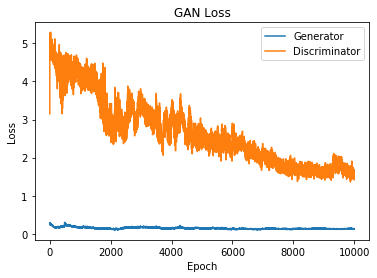

In [8]:
plt.plot(g_loss)
plt.plot(d_loss)
plt.title('GAN Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Generator', 'Discriminator'], loc='upper right')
plt.show()